# Laboratorio 2 - Series de tiempo

* José Eduardo López Gómez (181045)
* Karina Alejandra Valladares Díaz (18005)
* Alexa Carolina Bravo (18831)
* Esteban Cabrera (17781)


De forma inicial, se importan las librerias necesarias para trabajar. Además de las usuales, como numpy, se utilizará pandas para el manejo de las bases de datos, matplotlib para crear gráficas, datetime para crear formato en fechas y seaborn y seasonal_decompose para manejar las series de tiempo.

In [2]:
#importamos las librerías necesarias para trabajar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import statsmodels.api as sm

import datetime

In [108]:
from fbprophet import Prophet

In [3]:
!pip install pmdarima


Leemos ambos *.csv* en cuestión:

In [4]:
imp_com_id = pd.read_csv("DatosImportacionCombustibles.csv")
con_com_id = pd.read_csv("DatosConsumoCombustibles.csv")

Creamos una función que determina, como vector, las fechas de cada registro en los datos. Luego, se sobreescribe esta columna en el *dataframe*, con el fin de manejarlo más adelante dentro de las gráficas y el estudio de los datos.

In [5]:
def formato_fecha(df):
    fechas = []
    for i in range(0, len(df)):
        fecha = str(datetime.date(int(df["Anio"][i]), int(df["Mes"][i]), 1))
        fechas.append(fecha)
    
    df["Fechas"] = fechas

Para el dataframe **datos importaciones combustibles**, puede observarse que se cuenta con 245 filas y 29 columnas, dentro de las cuales existe una cantidad considerable de datos no disponibles (NaN). En particular, a primera vista esto es evidente para las columnas de "DieselLS", "DieselULS", "Solventes", "Naftas", "Ceras", "Butano", "Orimulsion", "MezclasOleosas" y "PetroleoCrudo".

In [6]:
imp_com_id

,Unnamed: 0,Anio,Mes,GasolinaSuper,GasolinaRegular,TotalGasolinas,Diesel,DieselLS,DieselULS,TotalDiesel,GLP,GasolinaAviacion,Kerosina,TurboJet,Bunker,Asfalto,PetCoke,AceitesLubricantes,GrasasLubricantes,Solventes,Naftas,Ceras,Butano,PetroleoReconstit,MTBE,Orimulsion,MezclasOleosas,PetroleoCrudo,TotalMensual
0,3,2001,1,373963.96,177776.50,551740.46,566101.99,NaN,NaN,566101.99,194065.74,820.00,33834.03,NaN,214581.84,27748.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,715344.0,8402.0,NaN,NaN,NaN,2312639.05
1,4,2001,2,243091.07,123115.99,366207.06,489525.80,NaN,NaN,489525.80,170703.38,3054.00,67439.95,NaN,294609.00,7503.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,370166.0,NaN,NaN,NaN,NaN,1769208.76
2,5,2001,3,312084.38,161726.42,473810.80,575559.68,NaN,NaN,575559.68,161837.37,677.00,31787.29,NaN,315263.80,26304.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360530.0,NaN,NaN,NaN,NaN,1945770.26
3,6,2001,4,285054.89,127338.74,412393.63,437745.42,NaN,NaN,437745.42,163048.64,3399.00,25801.18,NaN,205653.00,7885.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,359527.0,8184.0,NaN,NaN,NaN,1623637.76
4,7,2001,5,300913.67,168730.19,469643.86,552609.13,NaN,NaN,552609.13,171518.86,585.00,45529.33,NaN,278371.30,8443.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,723346.0,12680.0,NaN,NaN,NaN,2262726.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,316,2021,1,642652.37,626537.48,1269189.85,NaN,1185644.96,1499.38,1187144.34,475619.63,NaN,NaN,34039.29,74116.04,2857.14,360218.54,30676.78,559.25,13170.43,NaN,158.88,NaN,NaN,NaN,NaN,285.71,NaN,3448035.88
241,416,2021,2,726508.78,715261.34,1441770.12,NaN,1076824.67,1203.34,1078028.01,617782.99,NaN,NaN,36199.22,90475.23,2944.55,NaN,25287.66,469.36,13709.49,2.85,597.30,NaN,NaN,NaN,NaN,1941.72,NaN,3309208.50
242,516,2021,3,850334.64,772750.01,1623084.65,NaN,1345110.18,13415.05,1358525.23,604151.98,22193.67,NaN,44504.81,219041.83,2766.58,232451.50,39423.46,512.05,3207.39,48.00,329.90,NaN,NaN,NaN,NaN,1543.65,NaN,4151784.70
243,66,2021,4,1227173.53,634408.89,1861582.42,NaN,1250171.58,39568.59,1289740.17,664443.94,NaN,NaN,60378.83,134271.99,2373.03,NaN,34361.43,944.87,18218.88,NaN,331.40,NaN,NaN,NaN,NaN,1008.98,191.0,4067846.94


In [7]:
con_com_id

,Unnamed: 0,Anio,Mes,GasolinaSuper,GasolinaRegular,TotalGasolinas,Diesel,DieselLS,DieselULS,TotalDiesel,GLP,GasolinaAviacion,Kerosina,TurboJet,Bunker,Asfalto,PetCoke,AceitesLubricantes,GrasasLubricantes,Solventes,Naftas,Ceras,CrudoNacional,Butano,Orimulsion,MezclasOleosas,Total
0,3,2000,1,308156.82,202645.20,510802.02,634667.06,NaN,NaN,634667.06,194410.48,1426.00,64026.09,NaN,296766.99,48446.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1750544.64
1,4,2000,2,307766.31,205530.96,513297.27,642380.66,NaN,NaN,642380.66,174710.55,1458.00,62660.30,NaN,328116.44,50597.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1773220.22
2,5,2000,3,331910.29,229499.56,561409.85,699807.25,NaN,NaN,699807.25,189234.07,1503.00,61361.99,NaN,368589.63,27593.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1909498.79
3,6,2000,4,315648.08,210680.40,526328.48,586803.98,NaN,NaN,586803.98,174330.61,1561.00,61814.32,NaN,396300.47,53794.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1800932.86
4,7,2000,5,319667.97,208164.34,527832.31,656948.20,NaN,NaN,656948.20,191745.15,1642.00,54098.32,NaN,449368.92,60137.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1941771.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,194,2021,1,655503.47,685942.85,1341446.32,NaN,1220513.47,12064.41,1232577.88,472353.44,940.90,5222.38,37507.18,109730.56,26925.55,128264.67,28854.20,452.17,13958.41,88.32,NaN,108756.0,NaN,NaN,285.71,3507363.69
253,204,2021,2,621730.81,669313.36,1291044.17,NaN,1272593.63,10943.51,1283537.14,440394.46,1010.16,NaN,37044.54,141473.02,21953.78,286352.94,20240.35,709.18,9576.59,42.85,NaN,110937.0,NaN,NaN,NaN,3644007.36
254,214,2021,3,692228.61,679366.06,1371594.67,NaN,1417534.72,10508.49,1428043.21,509273.77,1291.15,115.36,36954.44,155028.06,29164.03,187420.65,27772.01,417.13,11000.25,95.13,NaN,104570.0,NaN,NaN,NaN,3862739.86
255,224,2021,4,610290.32,688389.15,1298679.47,NaN,1268514.31,9876.20,1278390.51,458849.58,1029.93,71.76,50964.69,124348.46,39782.05,222753.58,25691.62,441.80,12753.37,31.83,NaN,108795.0,NaN,NaN,83.00,3622666.65


Para el dataframe **datos consumo combustibles**, puede observarse que se cuenta con 257 filas y 27 columnas, dentro de las cuales existe una cantidad considerable de datos no disponibles (NaN). En particular, a primera vista esto es evidente para las columnas de "DieselLS", "DieselULS", "Solventes", "Naftas", "Ceras", "Butano", "Orimulsion", "MezclasOleosas" y "PetroleoCrudo".

Se eliminan las columnas innecesarias, dado que no contienen datos relevantes.

In [8]:
imp_com = imp_com_id.drop(columns = "Unnamed: 0")
con_com = con_com_id.drop(columns = "Unnamed: 0")

In [9]:
imp_com

,Anio,Mes,GasolinaSuper,GasolinaRegular,TotalGasolinas,Diesel,DieselLS,DieselULS,TotalDiesel,GLP,GasolinaAviacion,Kerosina,TurboJet,Bunker,Asfalto,PetCoke,AceitesLubricantes,GrasasLubricantes,Solventes,Naftas,Ceras,Butano,PetroleoReconstit,MTBE,Orimulsion,MezclasOleosas,PetroleoCrudo,TotalMensual
0,2001,1,373963.96,177776.50,551740.46,566101.99,NaN,NaN,566101.99,194065.74,820.00,33834.03,NaN,214581.84,27748.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,715344.0,8402.0,NaN,NaN,NaN,2312639.05
1,2001,2,243091.07,123115.99,366207.06,489525.80,NaN,NaN,489525.80,170703.38,3054.00,67439.95,NaN,294609.00,7503.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,370166.0,NaN,NaN,NaN,NaN,1769208.76
2,2001,3,312084.38,161726.42,473810.80,575559.68,NaN,NaN,575559.68,161837.37,677.00,31787.29,NaN,315263.80,26304.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360530.0,NaN,NaN,NaN,NaN,1945770.26
3,2001,4,285054.89,127338.74,412393.63,437745.42,NaN,NaN,437745.42,163048.64,3399.00,25801.18,NaN,205653.00,7885.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,359527.0,8184.0,NaN,NaN,NaN,1623637.76
4,2001,5,300913.67,168730.19,469643.86,552609.13,NaN,NaN,552609.13,171518.86,585.00,45529.33,NaN,278371.30,8443.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,723346.0,12680.0,NaN,NaN,NaN,2262726.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,2021,1,642652.37,626537.48,1269189.85,NaN,1185644.96,1499.38,1187144.34,475619.63,NaN,NaN,34039.29,74116.04,2857.14,360218.54,30676.78,559.25,13170.43,NaN,158.88,NaN,NaN,NaN,NaN,285.71,NaN,3448035.88
241,2021,2,726508.78,715261.34,1441770.12,NaN,1076824.67,1203.34,1078028.01,617782.99,NaN,NaN,36199.22,90475.23,2944.55,NaN,25287.66,469.36,13709.49,2.85,597.30,NaN,NaN,NaN,NaN,1941.72,NaN,3309208.50
242,2021,3,850334.64,772750.01,1623084.65,NaN,1345110.18,13415.05,1358525.23,604151.98,22193.67,NaN,44504.81,219041.83,2766.58,232451.50,39423.46,512.05,3207.39,48.00,329.90,NaN,NaN,NaN,NaN,1543.65,NaN,4151784.70
243,2021,4,1227173.53,634408.89,1861582.42,NaN,1250171.58,39568.59,1289740.17,664443.94,NaN,NaN,60378.83,134271.99,2373.03,NaN,34361.43,944.87,18218.88,NaN,331.40,NaN,NaN,NaN,NaN,1008.98,191.0,4067846.94


In [10]:
con_com

,Anio,Mes,GasolinaSuper,GasolinaRegular,TotalGasolinas,Diesel,DieselLS,DieselULS,TotalDiesel,GLP,GasolinaAviacion,Kerosina,TurboJet,Bunker,Asfalto,PetCoke,AceitesLubricantes,GrasasLubricantes,Solventes,Naftas,Ceras,CrudoNacional,Butano,Orimulsion,MezclasOleosas,Total
0,2000,1,308156.82,202645.20,510802.02,634667.06,NaN,NaN,634667.06,194410.48,1426.00,64026.09,NaN,296766.99,48446.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1750544.64
1,2000,2,307766.31,205530.96,513297.27,642380.66,NaN,NaN,642380.66,174710.55,1458.00,62660.30,NaN,328116.44,50597.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1773220.22
2,2000,3,331910.29,229499.56,561409.85,699807.25,NaN,NaN,699807.25,189234.07,1503.00,61361.99,NaN,368589.63,27593.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1909498.79
3,2000,4,315648.08,210680.40,526328.48,586803.98,NaN,NaN,586803.98,174330.61,1561.00,61814.32,NaN,396300.47,53794.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1800932.86
4,2000,5,319667.97,208164.34,527832.31,656948.20,NaN,NaN,656948.20,191745.15,1642.00,54098.32,NaN,449368.92,60137.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1941771.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,2021,1,655503.47,685942.85,1341446.32,NaN,1220513.47,12064.41,1232577.88,472353.44,940.90,5222.38,37507.18,109730.56,26925.55,128264.67,28854.20,452.17,13958.41,88.32,NaN,108756.0,NaN,NaN,285.71,3507363.69
253,2021,2,621730.81,669313.36,1291044.17,NaN,1272593.63,10943.51,1283537.14,440394.46,1010.16,NaN,37044.54,141473.02,21953.78,286352.94,20240.35,709.18,9576.59,42.85,NaN,110937.0,NaN,NaN,NaN,3644007.36
254,2021,3,692228.61,679366.06,1371594.67,NaN,1417534.72,10508.49,1428043.21,509273.77,1291.15,115.36,36954.44,155028.06,29164.03,187420.65,27772.01,417.13,11000.25,95.13,NaN,104570.0,NaN,NaN,NaN,3862739.86
255,2021,4,610290.32,688389.15,1298679.47,NaN,1268514.31,9876.20,1278390.51,458849.58,1029.93,71.76,50964.69,124348.46,39782.05,222753.58,25691.62,441.80,12753.37,31.83,NaN,108795.0,NaN,NaN,83.00,3622666.65


In [11]:
con_com.columns

Index(['Anio', 'Mes', 'GasolinaSuper', 'GasolinaRegular', 'TotalGasolinas',
       'Diesel', 'DieselLS', 'DieselULS', 'TotalDiesel', 'GLP',
       'GasolinaAviacion', 'Kerosina', 'TurboJet', 'Bunker', 'Asfalto',
       'PetCoke', 'AceitesLubricantes', 'GrasasLubricantes', 'Solventes',
       'Naftas', 'Ceras', 'CrudoNacional', 'Butano', 'Orimulsion',
       'MezclasOleosas', 'Total'],
      dtype='object')

In [12]:
imp_com.columns

Index(['Anio', 'Mes', 'GasolinaSuper', 'GasolinaRegular', 'TotalGasolinas',
       'Diesel', 'DieselLS', 'DieselULS', 'TotalDiesel', 'GLP',
       'GasolinaAviacion', 'Kerosina', 'TurboJet', 'Bunker', 'Asfalto',
       'PetCoke', 'AceitesLubricantes', 'GrasasLubricantes', 'Solventes',
       'Naftas', 'Ceras', 'Butano', 'PetroleoReconstit', 'MTBE', 'Orimulsion',
       'MezclasOleosas', 'PetroleoCrudo', 'TotalMensual'],
      dtype='object')

### Removemos todas las columnas que no vamos a utilizar

In [13]:
data_con = con_com.drop(columns = ['GLP',
       'GasolinaAviacion', 'Kerosina', 'TurboJet', 'Bunker', 'Asfalto',
       'PetCoke', 'AceitesLubricantes', 'GrasasLubricantes', 'Solventes',
       'Naftas', 'Ceras', 'CrudoNacional', 'Butano', 'Orimulsion',
       'MezclasOleosas', 'DieselULS', 'TotalGasolinas', "Total", "TotalDiesel"])

data_imp = imp_com.drop(columns = ['GLP',
       'GasolinaAviacion', 'Kerosina', 'TurboJet', 'Bunker', 'Asfalto',
       'PetCoke', 'AceitesLubricantes', 'GrasasLubricantes', 'Solventes',
       'Naftas', 'Ceras', 'Butano', 'PetroleoReconstit', 'MTBE', 'Orimulsion',
       'MezclasOleosas', 'PetroleoCrudo', 'DieselULS', 'TotalGasolinas', "TotalMensual", "TotalDiesel"])

In [14]:
data_con

,Anio,Mes,GasolinaSuper,GasolinaRegular,Diesel,DieselLS
0,2000,1,308156.82,202645.20,634667.06,NaN
1,2000,2,307766.31,205530.96,642380.66,NaN
2,2000,3,331910.29,229499.56,699807.25,NaN
3,2000,4,315648.08,210680.40,586803.98,NaN
4,2000,5,319667.97,208164.34,656948.20,NaN
...,...,...,...,...,...,...
252,2021,1,655503.47,685942.85,NaN,1220513.47
253,2021,2,621730.81,669313.36,NaN,1272593.63
254,2021,3,692228.61,679366.06,NaN,1417534.72
255,2021,4,610290.32,688389.15,NaN,1268514.31


In [15]:
data_imp

,Anio,Mes,GasolinaSuper,GasolinaRegular,Diesel,DieselLS
0,2001,1,373963.96,177776.50,566101.99,NaN
1,2001,2,243091.07,123115.99,489525.80,NaN
2,2001,3,312084.38,161726.42,575559.68,NaN
3,2001,4,285054.89,127338.74,437745.42,NaN
4,2001,5,300913.67,168730.19,552609.13,NaN
...,...,...,...,...,...,...
240,2021,1,642652.37,626537.48,NaN,1185644.96
241,2021,2,726508.78,715261.34,NaN,1076824.67
242,2021,3,850334.64,772750.01,NaN,1345110.18
243,2021,4,1227173.53,634408.89,NaN,1250171.58


### Unimos los datos de Dieseil y Diesel Bajo en Azufre

In [16]:
def agregar_diesel(df):
    for i in range(0, len(df)):
        if df["Anio"][i] == 2018 or df["Anio"][i] == 2019 or df["Anio"][i] == 2020 or df["Anio"][i] == 2021:
            df["Diesel"][i] = df["DieselLS"][i]
        else:
            df["Diesel"][i] == df["Diesel"][i]

In [17]:
agregar_diesel(data_con)
agregar_diesel(data_imp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [18]:
data_con

,Anio,Mes,GasolinaSuper,GasolinaRegular,Diesel,DieselLS
0,2000,1,308156.82,202645.20,634667.06,NaN
1,2000,2,307766.31,205530.96,642380.66,NaN
2,2000,3,331910.29,229499.56,699807.25,NaN
3,2000,4,315648.08,210680.40,586803.98,NaN
4,2000,5,319667.97,208164.34,656948.20,NaN
...,...,...,...,...,...,...
252,2021,1,655503.47,685942.85,1220513.47,1220513.47
253,2021,2,621730.81,669313.36,1272593.63,1272593.63
254,2021,3,692228.61,679366.06,1417534.72,1417534.72
255,2021,4,610290.32,688389.15,1268514.31,1268514.31


In [19]:
data_imp

,Anio,Mes,GasolinaSuper,GasolinaRegular,Diesel,DieselLS
0,2001,1,373963.96,177776.50,566101.99,NaN
1,2001,2,243091.07,123115.99,489525.80,NaN
2,2001,3,312084.38,161726.42,575559.68,NaN
3,2001,4,285054.89,127338.74,437745.42,NaN
4,2001,5,300913.67,168730.19,552609.13,NaN
...,...,...,...,...,...,...
240,2021,1,642652.37,626537.48,1185644.96,1185644.96
241,2021,2,726508.78,715261.34,1076824.67,1076824.67
242,2021,3,850334.64,772750.01,1345110.18,1345110.18
243,2021,4,1227173.53,634408.89,1250171.58,1250171.58


In [20]:
data_con.drop(columns = ["DieselLS"], inplace = True)
data_imp.drop(columns = ["DieselLS"],  inplace = True)

### Revisamos por datos nulos o faltantes en ambos sets de datos

In [21]:
data_con.isna().sum().to_frame()

,0
Anio,0
Mes,0
GasolinaSuper,0
GasolinaRegular,0
Diesel,0


In [22]:
data_imp.isna().sum().to_frame()

,0
Anio,0
Mes,0
GasolinaSuper,0
GasolinaRegular,0
Diesel,0


### Hacemos pair plos para ver la correlación

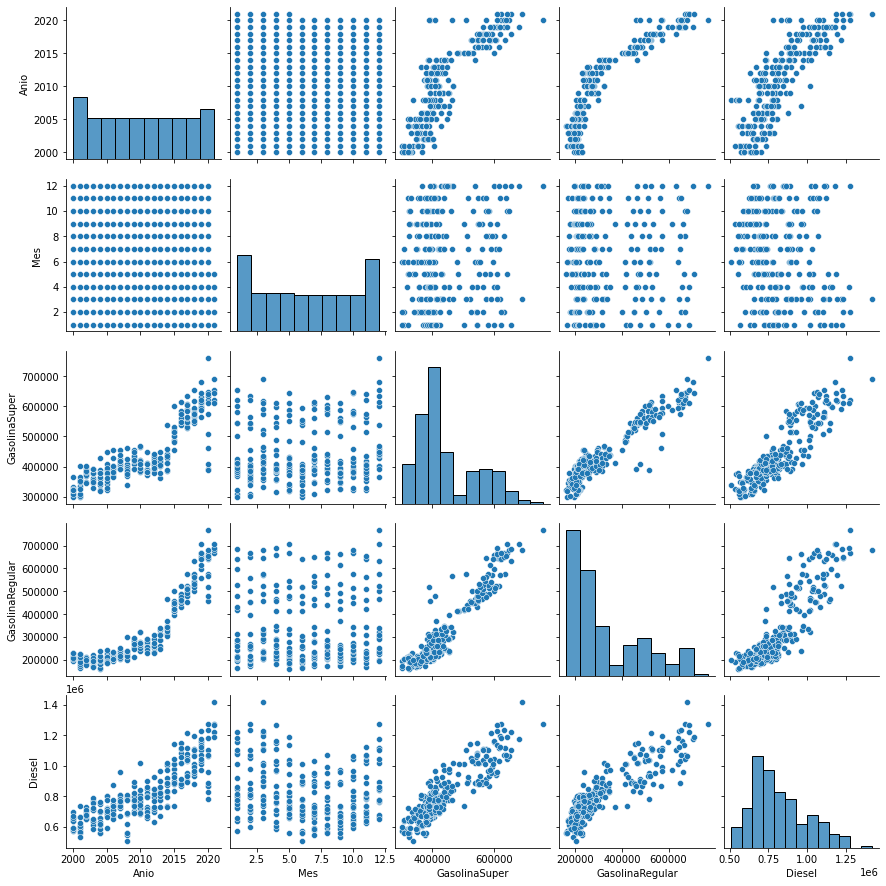

In [23]:
sns.pairplot(data_con)

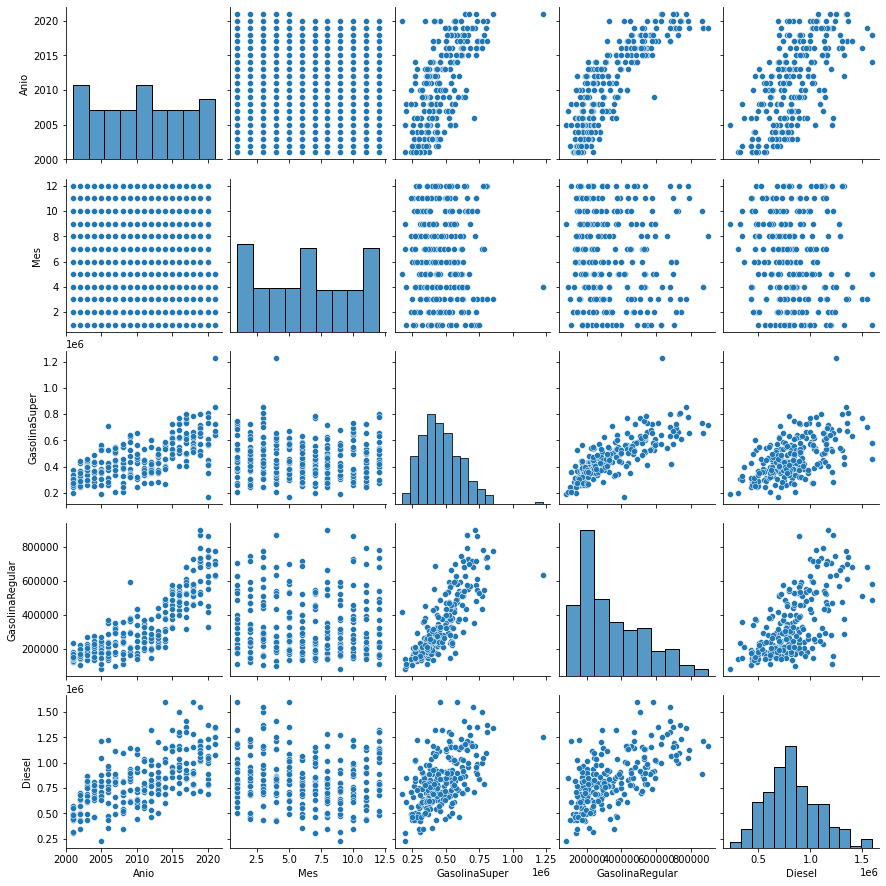

In [24]:
sns.pairplot(data_imp)

### Box Plot para Consumo

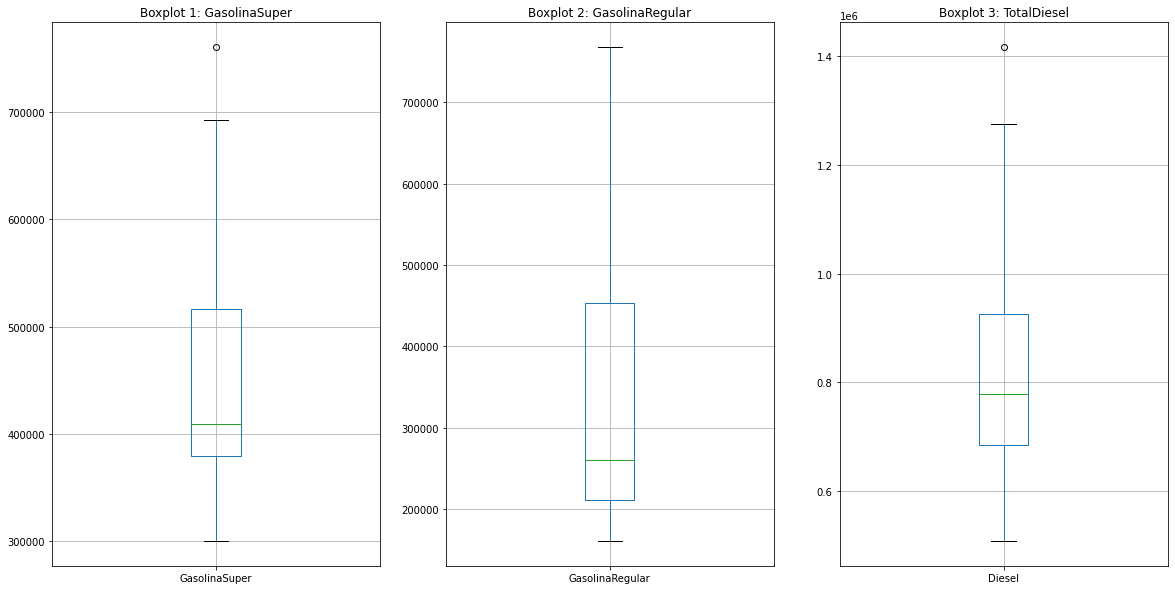

In [25]:
fig = plt.figure(figsize=(20,10)) 
ax = fig.add_subplot(131)
data_con.boxplot("GasolinaSuper")
ax.set_title("Boxplot 1: GasolinaSuper")
ax = fig.add_subplot(132)
data_con.boxplot("GasolinaRegular")
plt.title('Boxplot 2: GasolinaRegular')
ax = fig.add_subplot(133)
data_con.boxplot("Diesel")
ax.set_title("Boxplot 3: TotalDiesel")
plt.axis('tight')
plt.show()

### Box Plot para Importaciones

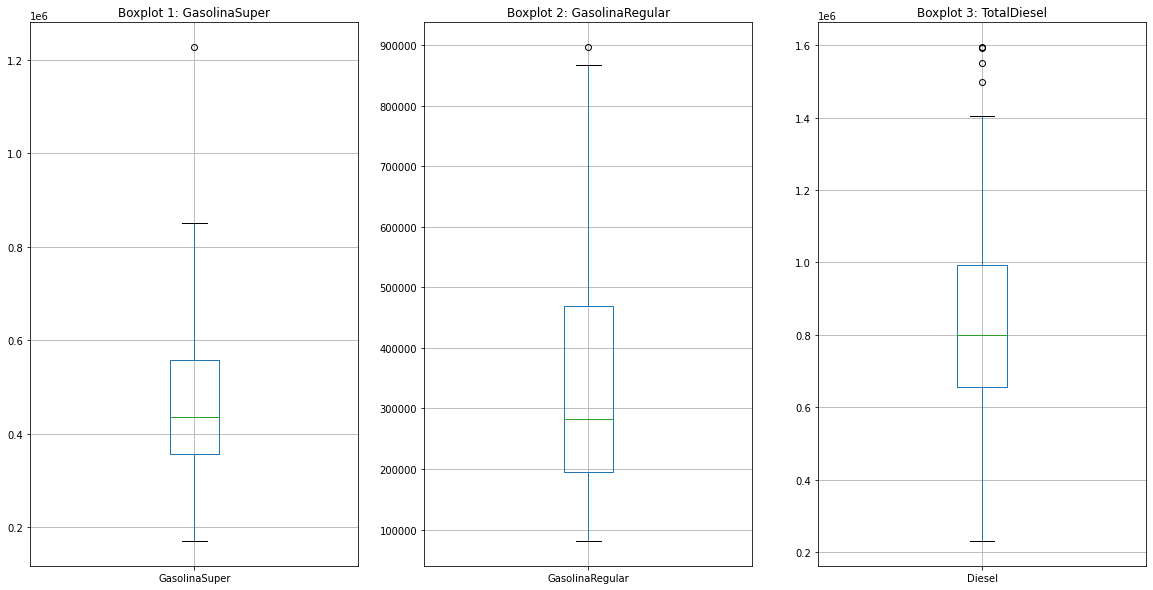

In [26]:
fig = plt.figure(figsize=(20,10)) 
ax = fig.add_subplot(131)
data_imp.boxplot("GasolinaSuper")
ax.set_title("Boxplot 1: GasolinaSuper")
ax = fig.add_subplot(132)
data_imp.boxplot("GasolinaRegular")
plt.title('Boxplot 2: GasolinaRegular')
ax = fig.add_subplot(133)
data_imp.boxplot("Diesel")
ax.set_title("Boxplot 3: TotalDiesel")
plt.axis('tight')
plt.show()

En general, los diagramas de caja y bigotes muestran que en cada tipo de gasolina existe una distribución normal. A pesar del distanciamiento de los datos de la media, no se presentan muchos datos atípicos. Con este tipo de analisis se pueden obtener series de tiempo que tengan sentido. Además, se pueden obtener distintos comportamientos y puede ser necesario una normalización de datos para poder realizar predicciones de manera correcta.

### Histogramas para Consumo

In [27]:
columnas = ["GasolinaSuper", "GasolinaRegular", "Diesel"]

<Figure size 1440x720 with 0 Axes>

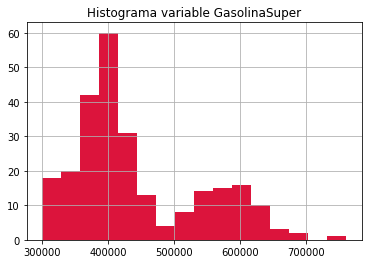

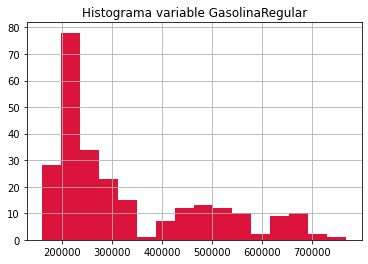

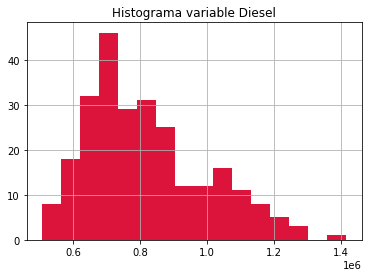

In [28]:
fig1 = plt.figure(figsize=(20,10)) 
for k in columnas:
    data_con.hist(k, bins = 16, color = "crimson")
    plt.title("Histograma variable " + str(k))

En los histogramas anteriores, es importante mencionar que ninguno parece tener una distribución normal. Para la **gasolina super**, puede observarse un sesgo hacia la izquierda de los datos y una especie de aumento cerca del final. La **gasolina regular** tiene un pico pronunciado del lado izquierdo, así como una serie de datos atípicos más adelante, por lo que tampoco es normal. Para el **diesel**, se observa un comportamiento que se podría aproximar a normal, sin embargo, sería necesario manipular los datos.

### Histogramas para Importaciones

<Figure size 1440x720 with 0 Axes>

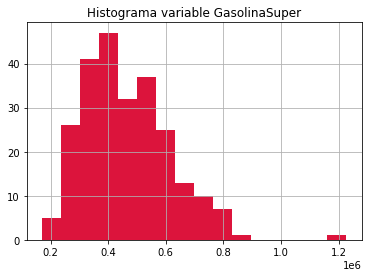

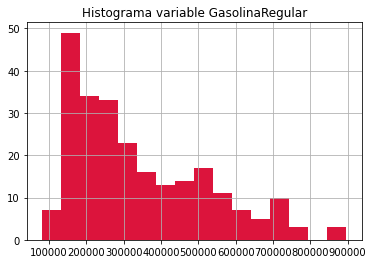

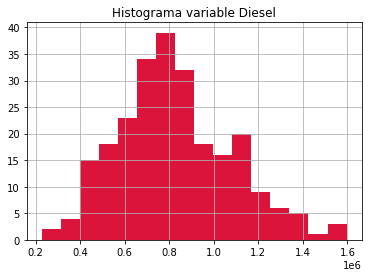

In [29]:
fig1 = plt.figure(figsize=(20,10)) 
for k in columnas:
    data_imp.hist(k, bins = 16, color = "crimson")
    plt.title("Histograma variable " + str(k))

El comportamiento de estos datos es significativamente distinto al anterior. En primera mano, es posible observar que no existe una gran cantidad de datos atípicos, sino más bien se ve un comportamiento aproximadamente normal para los datos. 

### Comparación Mensual para cada tipo de Gasolina de consumo

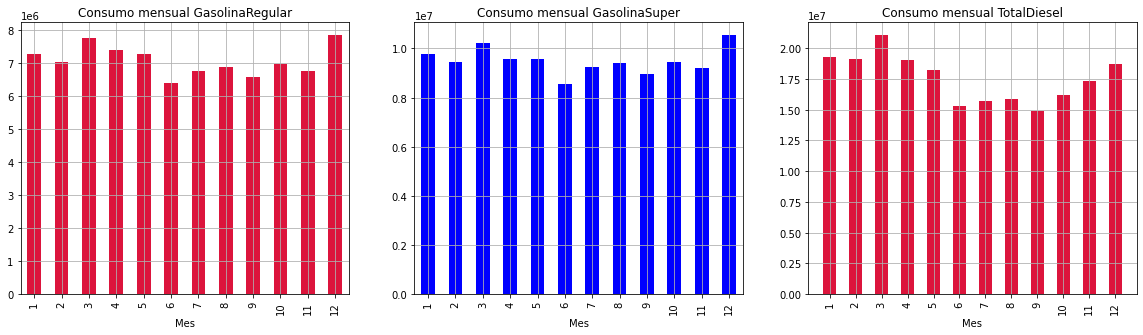

In [30]:
fig = plt.figure(figsize=(20,5)) 
ax = fig.add_subplot(131)
data_con.groupby('Mes').GasolinaRegular.sum().plot.bar(color = "crimson")
ax.set_title("Consumo mensual GasolinaRegular")
plt.grid()
ax = fig.add_subplot(132)
data_con.groupby('Mes').GasolinaSuper.sum().plot.bar(color = "blue")
ax.set_title("Consumo mensual GasolinaSuper")
plt.grid()
ax = fig.add_subplot(133)
data_con.groupby('Mes').Diesel.sum().plot.bar(color = "crimson")
ax.set_title("Consumo mensual TotalDiesel")
plt.grid()
plt.axis('tight')
plt.show()

### Comparación Mensual para cada tipo de Gasolina de importación

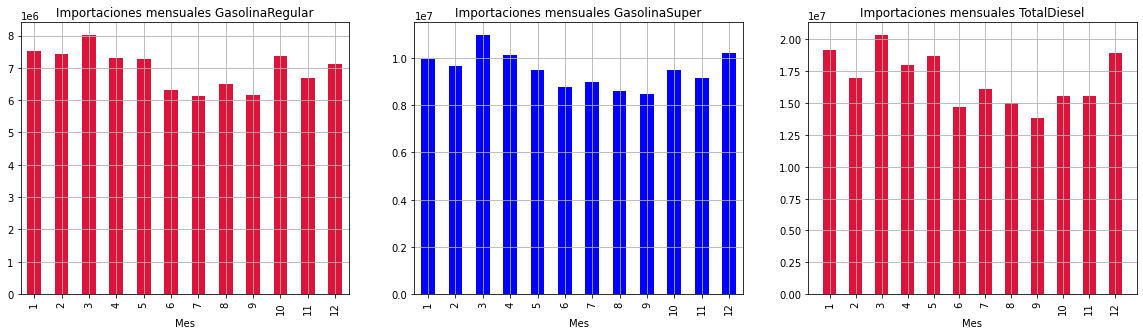

In [31]:
fig = plt.figure(figsize=(20,5)) 
ax = fig.add_subplot(131)
data_imp.groupby('Mes').GasolinaRegular.sum().plot.bar(color = "crimson")
ax.set_title("Importaciones mensuales GasolinaRegular")
plt.grid()
ax = fig.add_subplot(132)
data_imp.groupby('Mes').GasolinaSuper.sum().plot.bar(color = "blue")
ax.set_title("Importaciones mensuales GasolinaSuper")
plt.grid()
ax = fig.add_subplot(133)
data_imp.groupby('Mes').Diesel.sum().plot.bar(color = "crimson")
ax.set_title("Importaciones mensuales TotalDiesel")
plt.grid()
plt.axis('tight')
plt.show()

De forma inicial, para el **consumo mensual de gasolina regular** puede observarse que existe un consumo relativamente estable a lo largo de los meses. Puede verse un ligero aumento al final del primer trimestre del año, para luego reducirse significativamente en el primer semestre del año. Luego, vuelve a crecer, aunque no hay estabilidad en ello.

Para el **consumo mensual de gasolina super** inicialmente se observa un cambio en el factor del eje *y*. Si bien este se encuentra una decena por encima del anterior, al analizar los números, vemos que en realidad la cantidad está cercana, pues pocos meses alcanza el 1. 

Ahora bien, el **consumo mensual de gasolina diesel** es significativamente más fluctuante que los dos anteriores, así como es más alto. Es lógico pensar que tenga una mayor popularidad, dado el transporte pesado, los servicios de transporte y la fácil adquisición económica. En la gráfica es posible observar una caída por el mes 7, que luego empieza a crecer, sin llegar a los valores del inicio de año.

### Comparación Anual para cada tipo de Gasolina de consumo

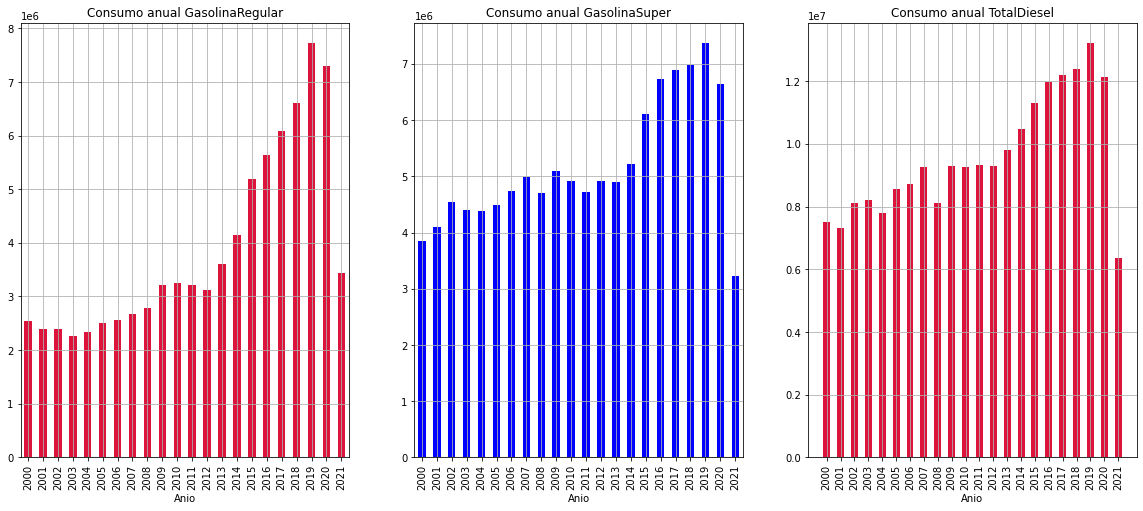

In [32]:
fig = plt.figure(figsize=(20,8)) 
ax = fig.add_subplot(131)
data_con.groupby('Anio').GasolinaRegular.sum().plot.bar(color = "crimson")
ax.set_title("Consumo anual GasolinaRegular")
plt.grid()
ax = fig.add_subplot(132)
data_con.groupby('Anio').GasolinaSuper.sum().plot.bar(color = "blue")
ax.set_title("Consumo anual GasolinaSuper")
plt.grid()
ax = fig.add_subplot(133)
data_con.groupby('Anio').Diesel.sum().plot.bar(color = "crimson")
ax.set_title("Consumo anual TotalDiesel")
plt.grid()
plt.axis('tight')
plt.show()

El comportamiento en la gasolina de consumo tiene un comportamiento bastante definido, y es que ha aumentado de forma casi estable a lo largo de todos los años. Se observa además un pico pronunciado en el consumo del año 2019, que sobresale ante los años anteriores. Sin embargo, vemos que el consumo para el año 2020 es significativamente menor en todos los casos, asemejándose sobremanera al comportamiento que se tuvo en 2012, 8 años antes. Este fenómeno sigue a 2021. Dicha fluctuación puede explicarse para el 2020 por la pandemia de la COVID19, así como la clausura masiva que nuestra nación tuvo como medida de prevención. Ahora bien, ese comportamiento se exporta hacia 2021, sí, sin embargo también cabe mencionar que los registros para el año actual no están completos, puesto que el año no ha terminado.


### Comparación Anual para cada tipo de Gasolina de Importaciones

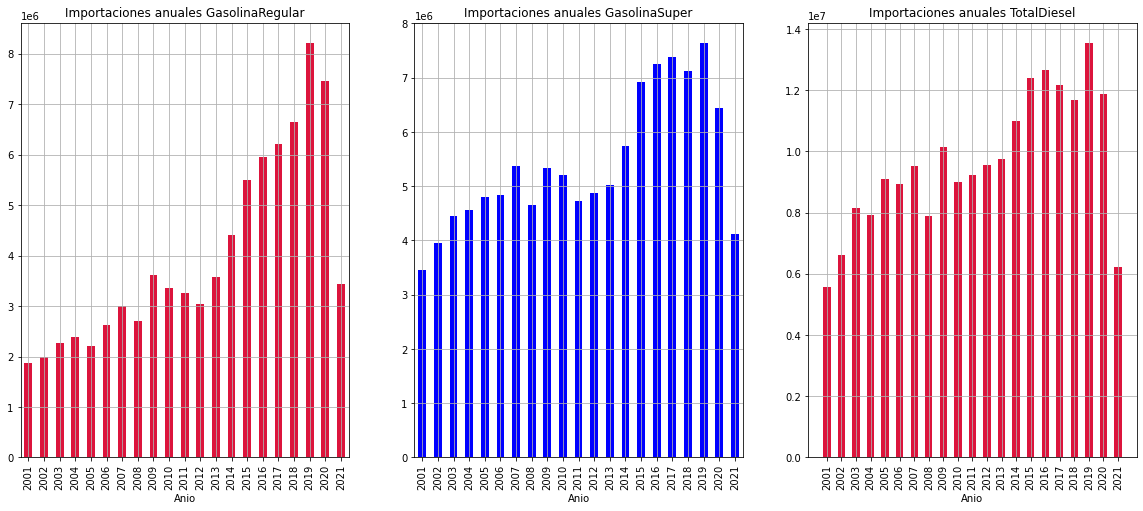

In [33]:
fig = plt.figure(figsize=(20,8)) 
ax = fig.add_subplot(131)
data_imp.groupby('Anio').GasolinaRegular.sum().plot.bar(color = "crimson")
ax.set_title("Importaciones anuales GasolinaRegular")
plt.grid()
ax = fig.add_subplot(132)
data_imp.groupby('Anio').GasolinaSuper.sum().plot.bar(color = "blue")
ax.set_title("Importaciones anuales GasolinaSuper")
plt.grid()
ax = fig.add_subplot(133)
data_imp.groupby('Anio').Diesel.sum().plot.bar(color = "crimson")
ax.set_title("Importaciones anuales TotalDiesel")
plt.grid()
plt.axis('tight')
plt.show()

La **importación anual de gasolina regular** tiene una importación baja en los primeros años y luego podemos observar como esta va aumentando, formando una gráfica con un sesgo moderado hacia la izquierda. 

En la grafica de **importación anual de gasolina super** podemos observar que inicia con una importación más alta que la gasolina regular, el cual va aumentando moderadamente formando un pequeño sesgo hacia la izquierda. 

En la **importación anual de Diesel** podemos observar que va en aumento e incluso en cuatro años se mantuvo casi constante y luego incremento significativamente. 

En estas tres gráficas podemos observar como el consumo disminuye en 2020 que es el año en el que todos nos vimos afectados por la pandemia y en 2021 es mucho mas bajo porque es el año en curso. 

## Series de tiempo para Consumo

### Transformamos los datos a tipo fecha

In [34]:
formato_fecha(data_con)
formato_fecha(data_imp)

In [35]:
data_con.index = data_con["Fechas"]

In [36]:
data_imp.index = data_imp["Fechas"]

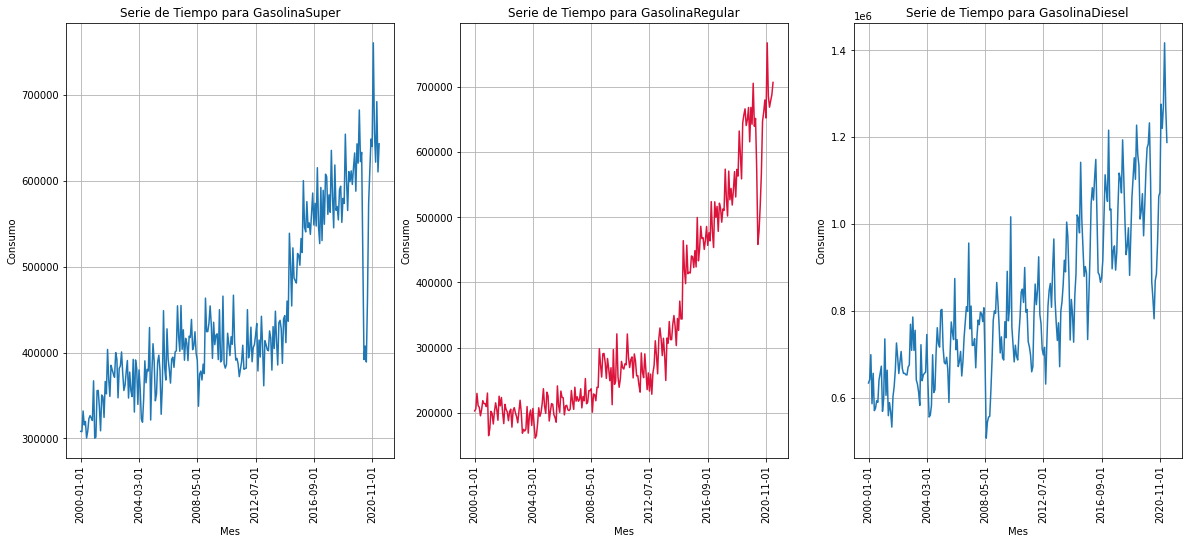

In [37]:
fig = plt.figure(figsize=(20,8)) 
ax = fig.add_subplot(131)
data_con["GasolinaSuper"].plot()
plt.grid()
plt.title("Serie de Tiempo para GasolinaSuper")
plt.ylabel("Consumo")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(132)
data_con["GasolinaRegular"].plot(color = "crimson")
plt.grid()
plt.title("Serie de Tiempo para GasolinaRegular")
plt.ylabel("Consumo")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(133)
data_con["Diesel"].plot()
plt.grid()
plt.title("Serie de Tiempo para GasolinaDiesel")
plt.ylabel("Consumo")
plt.xlabel("Mes")
plt.xticks(rotation=90)
plt.axis('tight')
plt.show()

El consumo de gasolina presenta un consumo creciente a lo largo del tiempo, independientemente de la clase de gasolina que se esté analizando. Como es posible observar, la **GasolinaSuper** presenta un comportamiento ligeramente fluctuante en los primeros años, mostrando un aumento significativo en 2004. Luego, el crecimiento es estable, hasta 2014, en el que tiene un salto alto. Además, se observa una caída significativa alrededor de medio año del 2020, lo que es lógico al considerar los efectos de la pandemia y cómo alteró los hábitos de consumo. 

Por su parte, el consumo de la **GasolinaRegular** muestra un crecimiento estable hasta 2014, punto en el cual da un salto hacia arriba y su consumo crece significativamente, en comparación a los datos históricos previos. Es posible observar una caída en el consumo cerca de agosto de 2020, aunque esta no es tan pronunciada como la anterior. 

Por su parte, el consumo de Diesel es el más errático de todos. Si bien presenta una cota por arriba y por abajo, los saltos entre puntos son marcados y sumamente aleatorios. De forma similar a los casos anteriores, es posible observar una caída en el consumo cerca de 2020, explicable por la pandemia.

### Series de tiempo para Importaciones

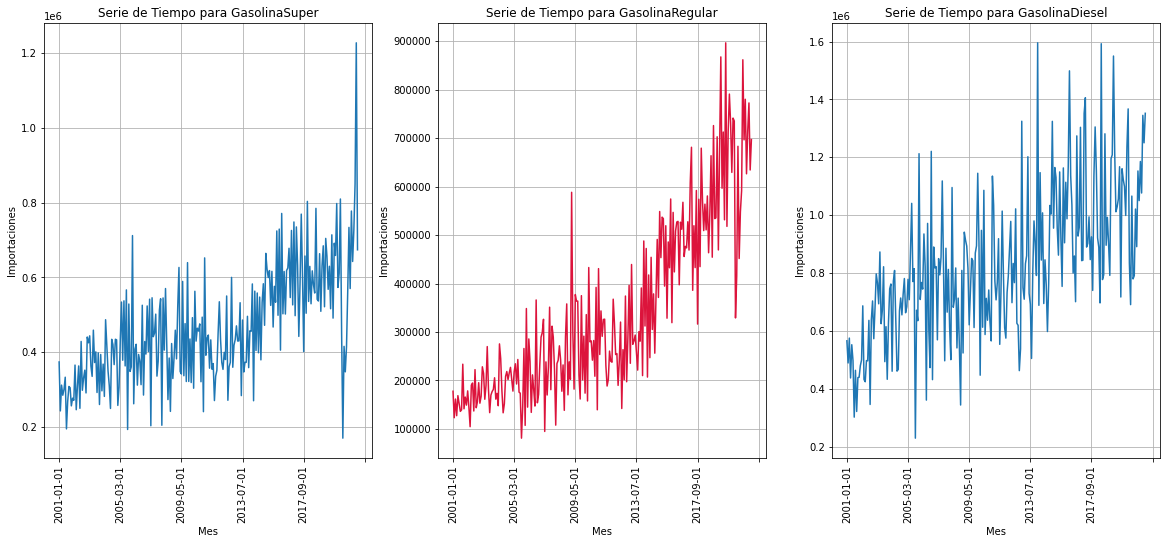

In [38]:
fig = plt.figure(figsize=(20,8)) 
ax = fig.add_subplot(131)
data_imp["GasolinaSuper"].plot()
plt.grid()
plt.title("Serie de Tiempo para GasolinaSuper")
plt.ylabel("Importaciones")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(132)
data_imp["GasolinaRegular"].plot(color = "crimson")
plt.grid()
plt.title("Serie de Tiempo para GasolinaRegular")
plt.ylabel("Importaciones")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(133)
data_imp["Diesel"].plot()
plt.grid()
plt.title("Serie de Tiempo para GasolinaDiesel")
plt.ylabel("Importaciones")
plt.xlabel("Mes")
plt.xticks(rotation=90)
plt.axis('tight')
plt.show()

Como es de esperarse, el comportamiento de las importaciones de gasolina son bastante similares al consumo. Dado que la demanda crea oferta, podemos observar el mismo crecimiento en los primeros años en las tres clases de combustibles, con una caída significativa a lo largo del 2020, y un repunte a inicios de 2021.

### Segmentos la Data para los últimos 3 años

In [39]:
data_separar_con = data_con
data_separar_imp = data_imp

In [40]:
data_con = data_separar_con.iloc[:216, :]
data_con_test = data_separar_con.iloc[215:,:]

data_imp = data_separar_imp.iloc[:202, :]
data_imp_test = data_separar_imp.iloc[201:, :]

### Segmentamos la Data para 2021

Puesto que se hará un estudio específico para el año actual, separamos los datos a ser utilizados.

In [41]:
data_2021_con = data_separar_con.iloc[252:, :]
data_2021_imp = data_separar_imp.iloc[240:, :]

In [42]:
data_2021_con

,Anio,Mes,GasolinaSuper,GasolinaRegular,Diesel,Fechas
Fechas,,,,,,
2021-01-01,2021,1,655503.47,685942.85,1220513.47,2021-01-01
2021-02-01,2021,2,621730.81,669313.36,1272593.63,2021-02-01
2021-03-01,2021,3,692228.61,679366.06,1417534.72,2021-03-01
2021-04-01,2021,4,610290.32,688389.15,1268514.31,2021-04-01
2021-05-01,2021,5,643104.75,707336.50,1188244.26,2021-05-01


In [43]:
data_2021_imp

,Anio,Mes,GasolinaSuper,GasolinaRegular,Diesel,Fechas
Fechas,,,,,,
2021-01-01,2021,1,642652.37,626537.48,1185644.96,2021-01-01
2021-02-01,2021,2,726508.78,715261.34,1076824.67,2021-02-01
2021-03-01,2021,3,850334.64,772750.01,1345110.18,2021-03-01
2021-04-01,2021,4,1227173.53,634408.89,1250171.58,2021-04-01
2021-05-01,2021,5,673824.38,697161.30,1352156.27,2021-05-01


In [44]:
data_con

,Anio,Mes,GasolinaSuper,GasolinaRegular,Diesel,Fechas
Fechas,,,,,,
2000-01-01,2000,1,308156.82,202645.20,634667.06,2000-01-01
2000-02-01,2000,2,307766.31,205530.96,642380.66,2000-02-01
2000-03-01,2000,3,331910.29,229499.56,699807.25,2000-03-01
2000-04-01,2000,4,315648.08,210680.40,586803.98,2000-04-01
2000-05-01,2000,5,319667.97,208164.34,656948.20,2000-05-01
...,...,...,...,...,...,...
2017-08-01,2017,8,604650.34,514086.57,950188.14,2017-08-01
2017-09-01,2017,9,560892.67,492618.55,894363.58,2017-09-01
2017-10-01,2017,10,583658.83,512762.32,935986.17,2017-10-01


In [45]:
data_con_test

,Anio,Mes,GasolinaSuper,GasolinaRegular,Diesel,Fechas
Fechas,,,,,,
2017-12-01,2017,12,635423.76,574097.70,1117711.45,2017-12-01
2018-01-01,2018,1,581802.98,528763.30,1105628.89,2018-01-01
2018-02-01,2018,2,545210.00,502041.67,1072071.67,2018-02-01
2018-03-01,2018,3,618402.18,571052.13,1194136.18,2018-03-01
2018-04-01,2018,4,565665.72,526979.67,1108452.97,2018-04-01
2018-05-01,2018,5,570129.66,544395.17,1009750.15,2018-05-01
2018-06-01,2018,6,554431.50,518911.44,930065.00,2018-06-01
2018-07-01,2018,7,589775.97,541811.12,950343.54,2018-07-01
2018-08-01,2018,8,593659.63,570224.11,991818.15,2018-08-01


In [46]:
data_imp

,Anio,Mes,GasolinaSuper,GasolinaRegular,Diesel,Fechas
Fechas,,,,,,
2001-01-01,2001,1,373963.96,177776.50,566101.99,2001-01-01
2001-02-01,2001,2,243091.07,123115.99,489525.80,2001-02-01
2001-03-01,2001,3,312084.38,161726.42,575559.68,2001-03-01
2001-04-01,2001,4,285054.89,127338.74,437745.42,2001-04-01
2001-05-01,2001,5,300913.67,168730.19,552609.13,2001-05-01
...,...,...,...,...,...,...
2017-06-01,2017,6,582374.34,519389.66,902659.00,2017-06-01
2017-07-01,2017,7,769214.06,433026.08,994338.30,2017-07-01
2017-08-01,2017,8,607368.72,592103.31,846696.35,2017-08-01


In [47]:
data_imp_test

,Anio,Mes,GasolinaSuper,GasolinaRegular,Diesel,Fechas
Fechas,,,,,,
2017-10-01,2017,10,657241.76,574073.61,740198.57,2017-10-01
2017-11-01,2017,11,504247.31,434963.36,1135350.10,2017-11-01
2017-12-01,2017,12,803216.88,679441.47,1305047.55,2017-12-01
2018-01-01,2018,1,535784.70,571858.06,1153831.89,2018-01-01
2018-02-01,2018,2,629467.91,509366.10,921684.12,2018-02-01
2018-03-01,2018,3,529507.15,563899.06,889227.10,2018-03-01
2018-04-01,2018,4,617512.28,510830.00,696962.77,2018-04-01
2018-05-01,2018,5,580329.35,580825.11,1592580.34,2018-05-01
2018-06-01,2018,6,558257.59,463620.61,777679.91,2018-06-01


## Descomposición para las series de tiempo

### Consumo: Gasolina Regular

In [48]:
resultRegular =seasonal_decompose(data_con['GasolinaRegular'], period = 21)

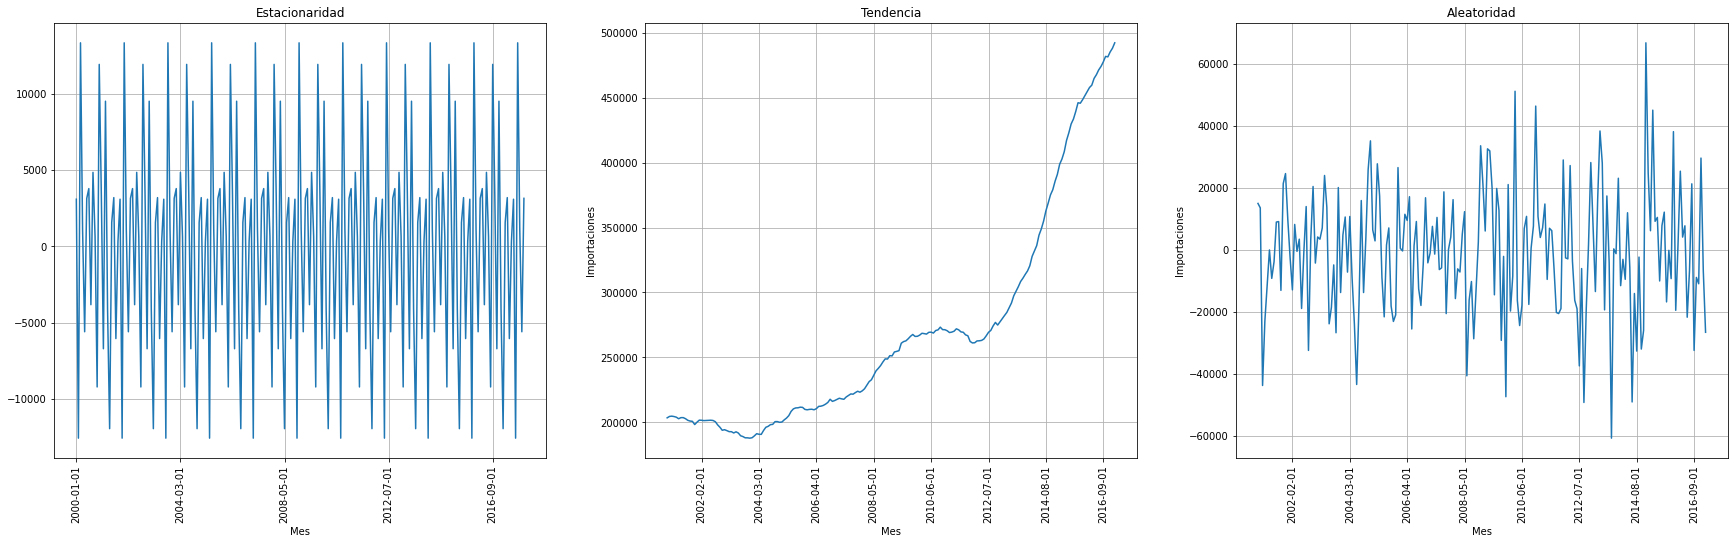

In [49]:
fig = plt.figure(figsize=(30,8)) 
ax = fig.add_subplot(131)
resultRegular.seasonal.plot()
plt.grid()
plt.title("Estacionaridad")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(132)
resultRegular.trend.plot()
plt.grid()
plt.title("Tendencia")
plt.ylabel("Importaciones")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(133)
resultRegular.resid.plot()
plt.grid()
plt.title("Aleatoridad")
plt.ylabel("Importaciones")
plt.xlabel("Mes")
plt.xticks(rotation=90)
plt.axis('tight')
plt.show()

Al observar las gráficas, puede verse que presentan claramente un periodo en el que el consumo mantiene un mismo comportamiento, y este se replica a lo largo de los años. Por otra parte, es importante mencionar el crecimiento en tendencia a lo largo de los años, con pequeñas fluctuaciones entre 2002 y 2004, 2004 y 2007 y a finales de 2011. Luego, a partir de 2013, puede verse que la tendencia crece indiscretamente. Además, el comportamiento de aleatoriedad parece ser cíclico.


### Consumo: Gasolina Super

In [50]:
resultSuper =seasonal_decompose(data_con['GasolinaSuper'], period = 21)

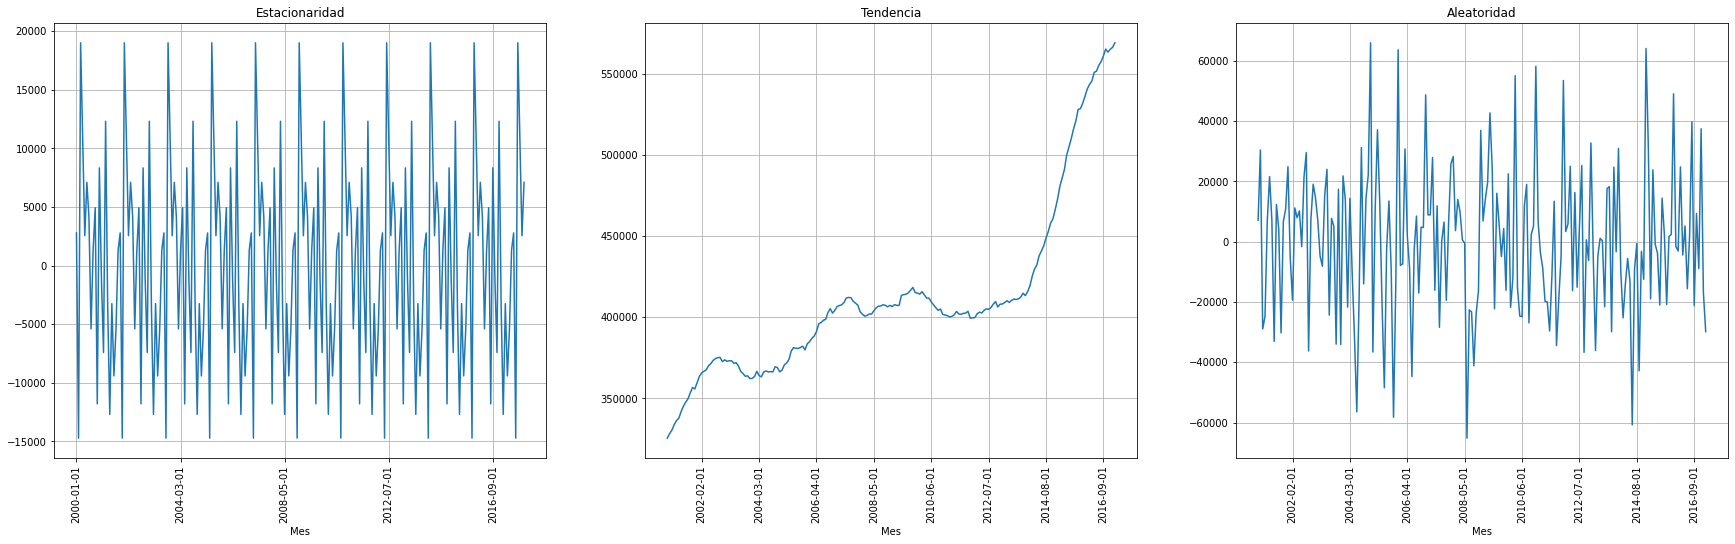

In [51]:
fig = plt.figure(figsize=(30,8)) 
ax = fig.add_subplot(131)
resultSuper.seasonal.plot()
plt.grid()
plt.title("Estacionaridad")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(132)
resultSuper.trend.plot()
plt.grid()
plt.title("Tendencia")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(133)
resultSuper.resid.plot()
plt.grid()
plt.title("Aleatoridad")
plt.xlabel("Mes")
plt.xticks(rotation=90)
plt.axis('tight')
plt.show()

Al observar las gráficas, el comportamiento de la GasolinaRegular es tremendamente similar al de la GasolinaSuper. Puede verse que presentan claramente un periodo en el que el consumo mantiene un mismo comportamiento, y este se replica a lo largo de los años. Por otra parte, es importante mencionar el crecimiento en tendencia a lo largo de los años, con pequeñas fluctuaciones entre 2002 y 2004, 2004 y 2007 y a finales de 2011. Luego, a partir de 2013, puede verse que la tendencia crece indiscretamente. Además, el comportamiento de aleatoriedad parece ser cíclico.

### Consumo: Gasolina Diesel

In [52]:
resultDiesel =seasonal_decompose(data_con['Diesel'], period = 21)

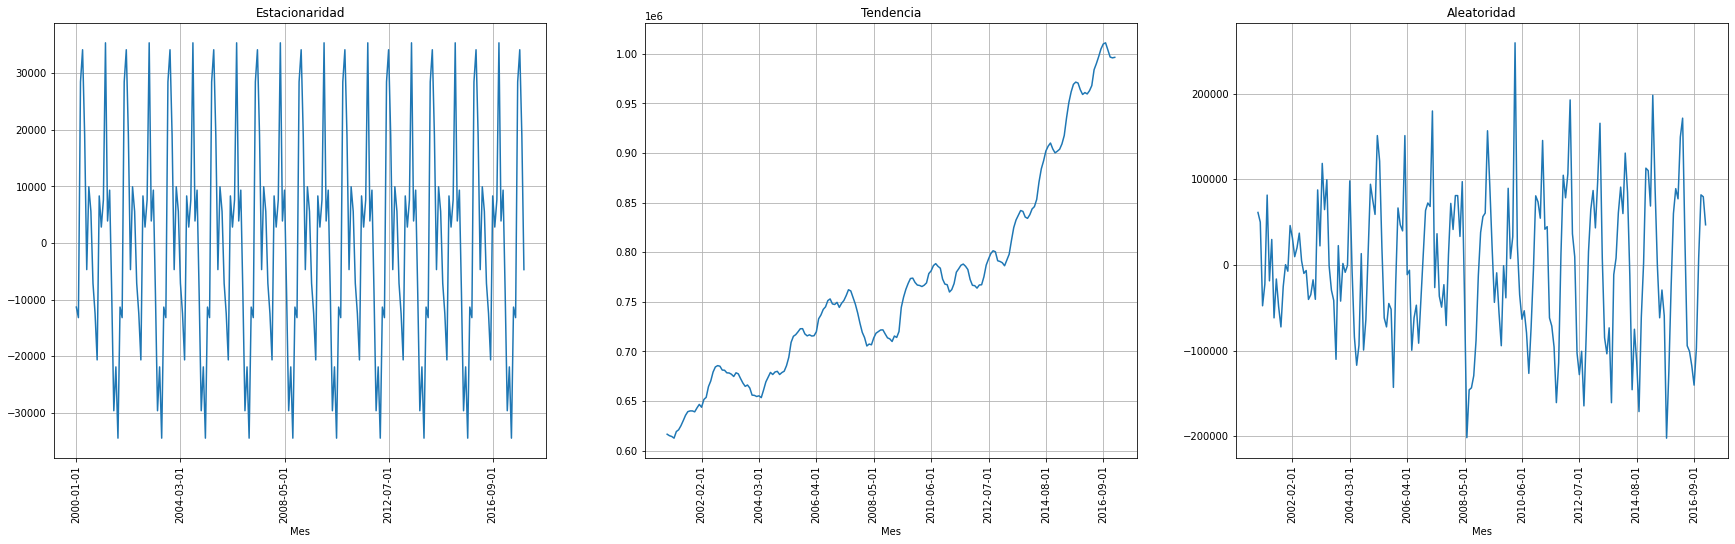

In [53]:
fig = plt.figure(figsize=(30,8)) 
ax = fig.add_subplot(131)
resultDiesel.seasonal.plot()
plt.grid()
plt.title("Estacionaridad")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(132)
resultDiesel.trend.plot()
plt.grid()
plt.title("Tendencia")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(133)
resultDiesel.resid.plot()
plt.grid()
plt.title("Aleatoridad")
plt.xlabel("Mes")
plt.xticks(rotation=90)
plt.axis('tight')
plt.show()

A diferencia de su contraparte, el consumo de diesel es un tanto más errático. Puede verse que es estacionario en cuanto a temporalidad, así como se observa un crecimiento a lo largo de la tendencia. AHora bien, su elemento aleatorio parece ir en aumento hasta 2010, para luego empezar a disminuir.

### Importaciones: Gasolina Regular

In [54]:
resultRegular =seasonal_decompose(data_imp['GasolinaRegular'], period = 21)

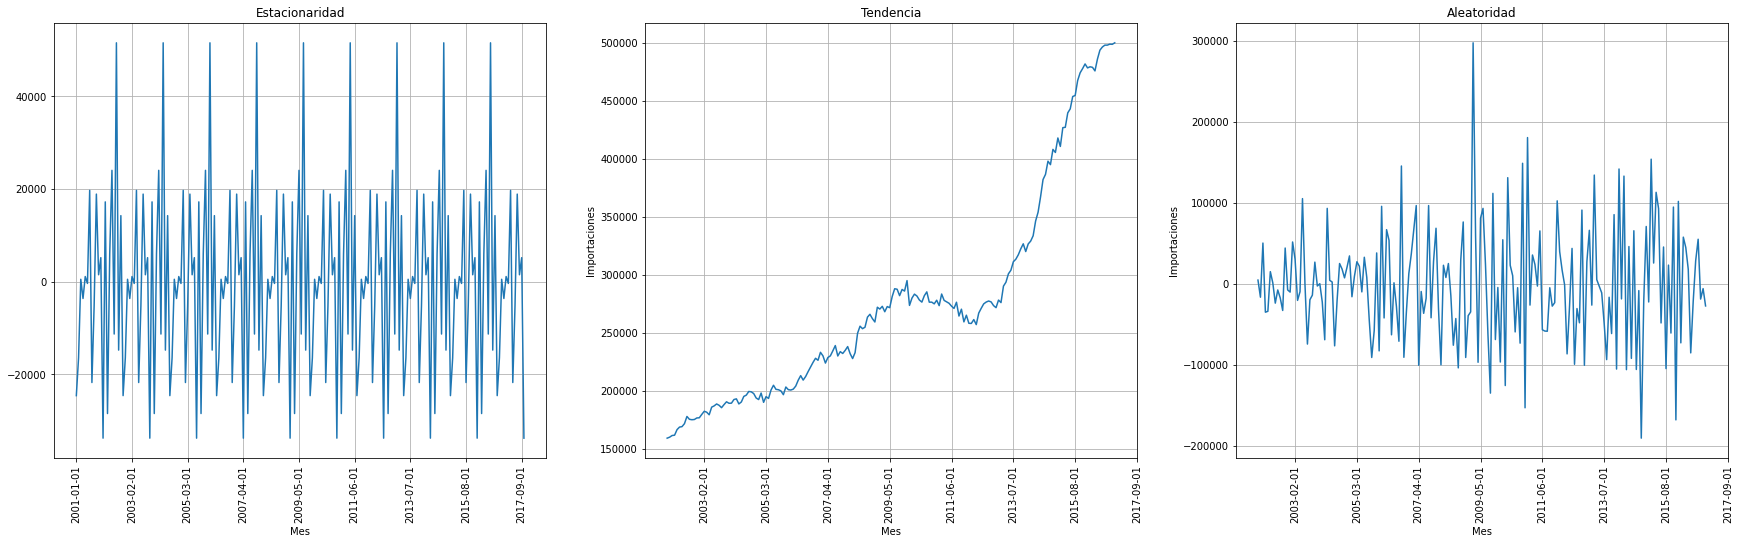

In [55]:
fig = plt.figure(figsize=(30,8)) 
ax = fig.add_subplot(131)
resultRegular.seasonal.plot()
plt.grid()
plt.title("Estacionaridad")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(132)
resultRegular.trend.plot()
plt.grid()
plt.title("Tendencia")
plt.ylabel("Importaciones")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(133)
resultRegular.resid.plot()
plt.grid()
plt.title("Aleatoridad")
plt.ylabel("Importaciones")
plt.xlabel("Mes")
plt.xticks(rotation=90)
plt.axis('tight')
plt.show()

Al observar las gráficas, puede verse que presentan claramente un periodo en el que el consumo mantiene un mismo comportamiento, y este se replica a lo largo de los años. Por otra parte, es importante mencionar el crecimiento en tendencia a lo largo de los años, con pequeñas fluctuaciones en intervalos particulares. Luego, a partir de 2013, puede verse que la tendencia crece indiscretamente. Además, el comportamiento de aleatoriedad parece ser cíclico, con perturbaciones eminentes en el medio.

### Importaciones: Gasolina Super

In [56]:
resultSuper =seasonal_decompose(data_imp['GasolinaSuper'], period = 21)

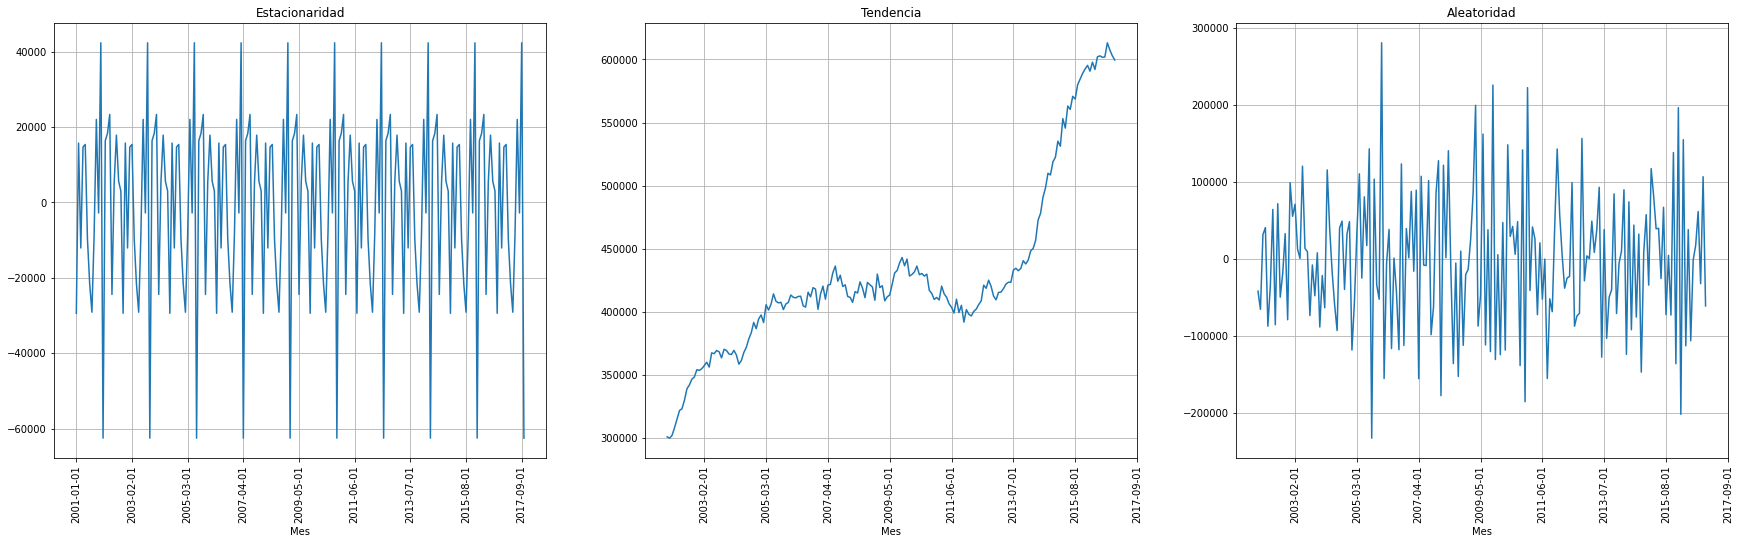

In [57]:
fig = plt.figure(figsize=(30,8)) 
ax = fig.add_subplot(131)
resultSuper.seasonal.plot()
plt.grid()
plt.title("Estacionaridad")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(132)
resultSuper.trend.plot()
plt.grid()
plt.title("Tendencia")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(133)
resultSuper.resid.plot()
plt.grid()
plt.title("Aleatoridad")
plt.xlabel("Mes")
plt.xticks(rotation=90)
plt.axis('tight')
plt.show()

El comportamiento observado para la importación de gasolina súper es similar a su comportamiento en consumo. Al observar las gráficas, puede verse que presentan claramente un periodo en el que el consumo mantiene un mismo comportamiento, y este se replica a lo largo de los años. Por otra parte, es importante mencionar el crecimiento en tendencia a lo largo de los años, con pequeñas fluctuaciones en intervalos particulares. Luego, a partir de 2013, puede verse que la tendencia crece indiscretamente. Además, el comportamiento de aleatoriedad parece ser cíclico, con perturbaciones eminentes en el medio.

### Importaciones: Gasolina Diesel

In [58]:
resultDiesel =seasonal_decompose(data_imp['Diesel'], period = 21)

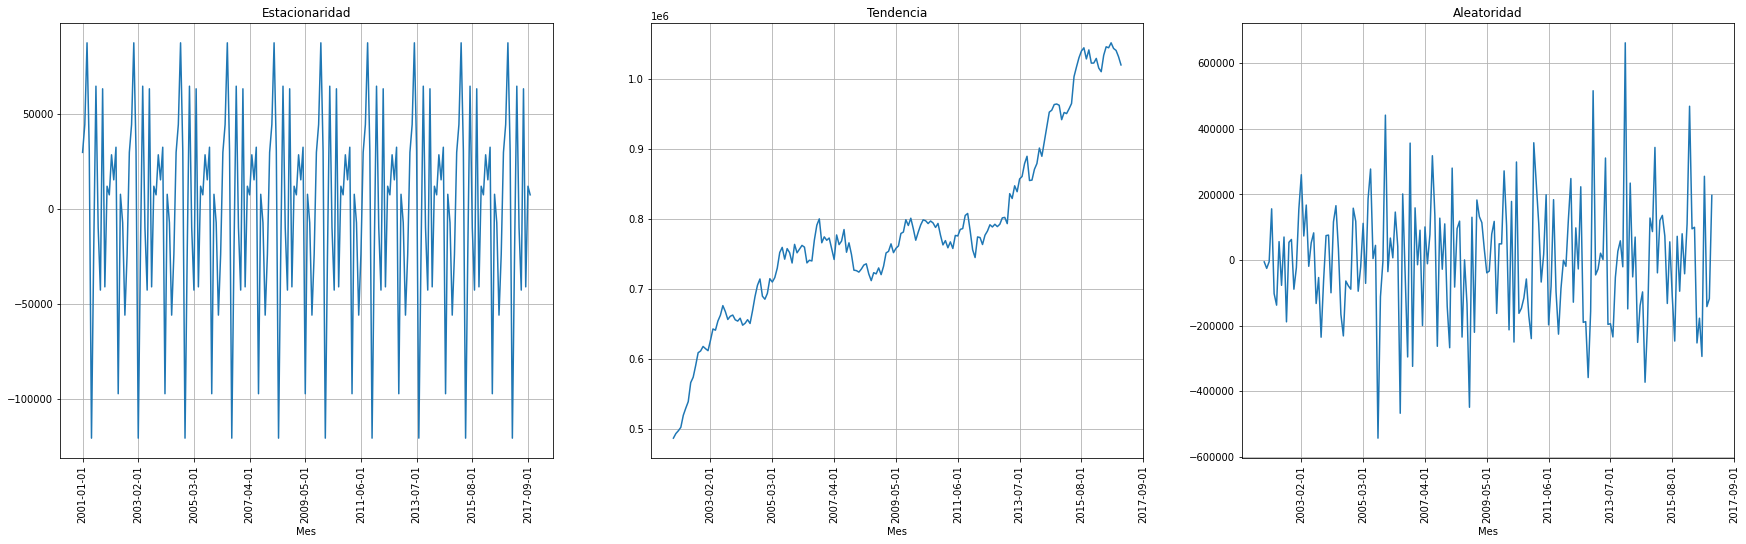

In [59]:
fig = plt.figure(figsize=(30,8)) 
ax = fig.add_subplot(131)
resultDiesel.seasonal.plot()
plt.grid()
plt.title("Estacionaridad")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(132)
resultDiesel.trend.plot()
plt.grid()
plt.title("Tendencia")
plt.xlabel("Mes")
plt.xticks(rotation=90)
ax = fig.add_subplot(133)
resultDiesel.resid.plot()
plt.grid()
plt.title("Aleatoridad")
plt.xlabel("Mes")
plt.xticks(rotation=90)
plt.axis('tight')
plt.show()

## Gráficos de Autocorrelación

### Para consumo

Text(0.5, 0, 'Lag')

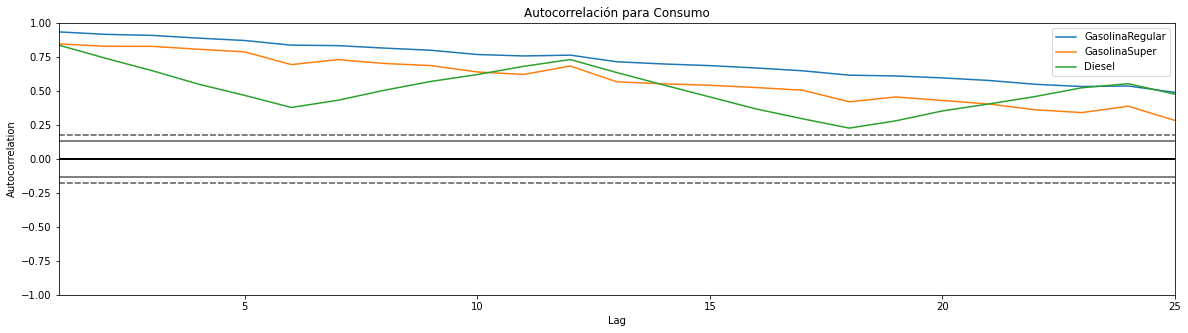

In [60]:
fig = plt.figure(figsize=(20,5)) 

pd.plotting.autocorrelation_plot(data_con["GasolinaRegular"], label = "GasolinaRegular").set_xlim([1, 25])
pd.plotting.autocorrelation_plot(data_con["GasolinaSuper"], label = "GasolinaSuper").set_xlim([1, 25])
pd.plotting.autocorrelation_plot(data_con["Diesel"], label = "Diesel").set_xlim([1, 25])
plt.grid()
plt.title("Autocorrelación para Consumo")
plt.xlabel("Lag")

### Para importaciones

Text(0.5, 0, 'Lag')

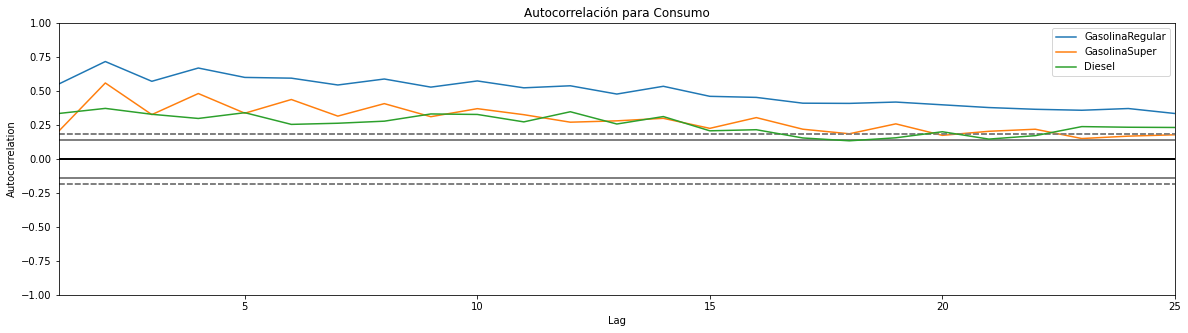

In [61]:
fig = plt.figure(figsize=(20,5)) 

pd.plotting.autocorrelation_plot(data_imp["GasolinaRegular"], label = "GasolinaRegular").set_xlim([1, 25])
pd.plotting.autocorrelation_plot(data_imp["GasolinaSuper"], label = "GasolinaSuper").set_xlim([1, 25])
pd.plotting.autocorrelation_plot(data_imp["Diesel"], label = "Diesel").set_xlim([1, 25])
plt.grid()
plt.title("Autocorrelación para Consumo")
plt.xlabel("Lag")

Al observar las gráficas, es posible inferir que existe una mayor correlación entre los datos para el consumo, que el de importación. Sin embargo, es importante mencionar que en ambos casos, la GasolinaRegular presenta un comportamiento mayor y separado de los otros dos elementos.

## Pruebas de Dickey - Fuller

En las pruebas estadísticas suponemos lo siguiente: 

- $H_{0}: $ tiene una raíz unitaria. No es estacionaria en $\mu$ y tiene dependencia del tiempo.
- $H_{1}: $ no tiene una raíz unitaria. Es estacionaria en $\mu$ y no tiene un dependecia del tiempo. 

Con el siguiente criterio: 

- Si el valor - $p > 0.05$ no se rechaza la hipótesis nula.
- Si el valor - $p \leq 0.05$ se rechaza la hipótesis nula.

### Prueba para el consumo de Gasolina Regular

In [62]:
Xregularcon = data_con["GasolinaRegular"].values

ResultRegularcon = adfuller(Xregularcon)

print('Estadístico: %f' % ResultRegularcon[0])
print('Valor - p: %f' % ResultRegularcon[1])
print('Valores críticos:')
for key, value in ResultRegularcon[4].items():
	print('\t%s: %.3f' % (key, value))

Estadístico: 2.218671
Valor - p: 0.998898
Valores críticos:
	1%: -3.463
	5%: -2.876
	10%: -2.574


Dado que el valor de $p > 0.05$, entonces no es posible rechazar la hipótesis nula, por lo que se tiene una raíz unitaria y los datos no es estacionaria en $\mu$ y tiene dependencia del tiempo.

### Prueba para el consumo de Gasolina Super

In [63]:
Xsupercon = data_con["GasolinaSuper"].values

ResultSupercon = adfuller(Xsupercon)

print('Estadístico: %f' % ResultSupercon[0])
print('Valor - p: %f' % ResultSupercon[1])
print('Valores críticos:')
for key, value in ResultSupercon[4].items():
	print('\t%s: %.3f' % (key, value))

Estadístico: 0.462689
Valor - p: 0.983694
Valores críticos:
	1%: -3.463
	5%: -2.876
	10%: -2.574


Dado que el valor de $p > 0.05$, entonces no es posible rechazar la hipótesis nula, por lo que se tiene una raíz unitaria y los datos no es estacionaria en $\mu$ y tiene dependencia del tiempo.

### Prueba para consumo de Gasolina Diesel

In [64]:
Xdieselcon = data_con["Diesel"].values

ResultDieselcon = adfuller(Xdieselcon)

print('Estadístico: %f' % ResultDieselcon[0])
print('Valor - p: %f' % ResultDieselcon[1])
print('Valores críticos:')
for key, value in ResultDieselcon[4].items():
	print('\t%s: %.3f' % (key, value))

Estadístico: 0.135228
Valor - p: 0.968386
Valores críticos:
	1%: -3.463
	5%: -2.876
	10%: -2.574


Dado que el valor de $p > 0.05$, entonces no es posible rechazar la hipótesis nula, por lo que se tiene una raíz unitaria y los datos no es estacionaria en $\mu$ y tiene dependencia del tiempo.

### Prueba para importaciones de Gasolina Regular

In [65]:
Xregularimp = data_imp["GasolinaRegular"].values

ResultRegularimp = adfuller(Xregularimp)

print('Estadístico: %f' % ResultRegularimp[0])
print('Valor - p: %f' % ResultRegularimp[1])
print('Valores críticos:')
for key, value in ResultRegularimp[4].items():
	print('\t%s: %.3f' % (key, value))

Estadístico: 0.696200
Valor - p: 0.989762
Valores críticos:
	1%: -3.466
	5%: -2.877
	10%: -2.575


Dado que el valor de $p > 0.05$, entonces no es posible rechazar la hipótesis nula, por lo que se tiene una raíz unitaria y los datos no es estacionaria en $\mu$ y tiene dependencia del tiempo.

### Prueba para importaciones de Gasolina Super

In [66]:
Xsuperimp = data_imp["GasolinaSuper"].values

ResultSuperimp = adfuller(Xsuperimp)

print('Estadístico: %f' % ResultSuperimp[0])
print('Valor - p: %f' % ResultSuperimp[1])
print('Valores críticos:')
for key, value in ResultSuperimp[4].items():
	print('\t%s: %.3f' % (key, value))

Estadístico: -1.709222
Valor - p: 0.426368
Valores críticos:
	1%: -3.464
	5%: -2.876
	10%: -2.575


Dado que el valor de $p > 0.05$, entonces no es posible rechazar la hipótesis nula, por lo que  se tiene una raíz unitaria y los datos no presentan estacionaria en $\mu$ y tiene dependencia del tiempo.

### Prueba para importaciones de Gasolina Diesel

In [67]:
Xdieselimp = data_imp["Diesel"].values

ResultDieselimp = adfuller(Xdieselimp)

print('Estadístico: %f' % ResultDieselimp[0])
print('Valor - p: %f' % ResultDieselimp[1])
print('Valores críticos:')
for key, value in ResultDieselimp[4].items():
	print('\t%s: %.3f' % (key, value))

Estadístico: -1.676655
Valor - p: 0.443179
Valores críticos:
	1%: -3.466
	5%: -2.877
	10%: -2.575


Dado que el valor de $p > 0.05$, entonces es posible rechazar la hipótesis nula, por lo que no se tiene una raíz unitaria y los datos presentan es estacionaria en $\mu$ y no tiene dependencia del tiempo.

### Aplicamos una Diferencia para ver que ocurre


# Primera diferencia

### Consumo: Gasolina Regular

In [68]:
data_con["GasolinaRegular"] = np.log(data_con["GasolinaRegular"])
diffregularcon = data_con["GasolinaRegular"].diff().dropna()

ResultRegularcon = adfuller(diffregularcon)

print('Estadístico: %f' % ResultRegularcon[0])
print('Valor - p: %f' % ResultRegularcon[1])
print('Valores críticos:')
for key, value in ResultRegularcon[4].items():
	print('\t%s: %.3f' % (key, value))

Estadístico: -5.006193
Valor - p: 0.000022
Valores críticos:
	1%: -3.463
	5%: -2.876
	10%: -2.574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Dado que el valor de $p \leq 0.05$, entonces es posible rechazar la hipótesis nula, por lo que no se tiene una raíz unitaria y los datos presentan es estacionaria en $\mu$ y no tiene dependencia del tiempo.

### Consumo: Gasolina Super

In [69]:
data_con["GasolinaSuper"] = np.log(data_con["GasolinaSuper"])
diffsupercon = data_con["GasolinaSuper"].diff().dropna()

ResultSupercon = adfuller(diffsupercon)

print('Estadístico: %f' % ResultSupercon[0])
print('Valor - p: %f' % ResultSupercon[1])
print('Valores críticos:')
for key, value in ResultSupercon[4].items():
	print('\t%s: %.3f' % (key, value))

Estadístico: -4.846303
Valor - p: 0.000044
Valores críticos:
	1%: -3.463
	5%: -2.876
	10%: -2.574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Consumo: Gasolina Diesel

In [70]:
data_con["Diesel"] = np.log(data_con["Diesel"])
diffdieselcon = data_con["Diesel"].diff().dropna()

ResultDieselcon = adfuller(diffdieselcon)

print('Estadístico: %f' % ResultDieselcon[0])
print('Valor - p: %f' % ResultDieselcon[1])
print('Valores críticos:')
for key, value in ResultDieselcon[4].items():
	print('\t%s: %.3f' % (key, value))

Estadístico: -6.147601
Valor - p: 0.000000
Valores críticos:
	1%: -3.463
	5%: -2.876
	10%: -2.574


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Dado que el valor de $p \leq 0.05$, entonces es posible rechazar la hipótesis nula, por lo que no se tiene una raíz unitaria y los datos presentan es estacionaria en $\mu$ y no tiene dependencia del tiempo.

### Importaciones: Gasolina Regular

In [71]:
data_imp["GasolinaRegular"] = np.log(data_imp["GasolinaRegular"])
diffregularimp = data_imp["GasolinaRegular"].diff().dropna()

ResultRegularimp = adfuller(diffregularimp)

print('Estadístico: %f' % ResultRegularimp[0])
print('Valor - p: %f' % ResultRegularimp[1])
print('Valores críticos:')
for key, value in ResultRegularimp[4].items():
	print('\t%s: %.3f' % (key, value))

Estadístico: -6.679157
Valor - p: 0.000000
Valores críticos:
	1%: -3.466
	5%: -2.877
	10%: -2.575


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Dado que el valor de $p \leq 0.05$, entonces es posible rechazar la hipótesis nula, por lo que no se tiene una raíz unitaria y los datos presentan es estacionaria en $\mu$ y no tiene dependencia del tiempo.

### Importaciones: Gasolina Super

In [94]:
data_imp["GasolinaSuper"] = np.log(data_imp["GasolinaSuper"])
diffsuperimp = data_imp["GasolinaSuper"].diff().dropna()

ResultSuperimp = adfuller(diffsuperimp)

print('Estadístico: %f' % ResultSuperimp[0])
print('Valor - p: %f' % ResultSuperimp[1])
print('Valores críticos:')
for key, value in ResultSuperimp[4].items():
	print('\t%s: %.3f' % (key, value))

Estadístico: -7.670932
Valor - p: 0.000000
Valores críticos:
	1%: -3.465
	5%: -2.877
	10%: -2.575


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Dado que el valor de $p \leq 0.05$, entonces es posible rechazar la hipótesis nula, por lo que no se tiene una raíz unitaria y los datos presentan es estacionaria en $\mu$ y no tiene dependencia del tiempo.

### Importaciones: Gasolina Diesel

In [93]:
data_imp["Diesel"] = np.log(data_imp["Diesel"])
diffdieselimp = data_imp["Diesel"].diff().dropna()

ResultDieselimp = adfuller(diffdieselimp)

print('Estadístico: %f' % ResultDieselimp[0])
print('Valor - p: %f' % ResultDieselimp[1])
print('Valores críticos:')
for key, value in ResultDieselimp[4].items():
	print('\t%s: %.3f' % (key, value))

Estadístico: -7.930140
Valor - p: 0.000000
Valores críticos:
	1%: -3.465
	5%: -2.877
	10%: -2.575


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Dado que el valor de $p \leq 0.05$, entonces es posible rechazar la hipótesis nula, por lo que no se tiene una raíz unitaria y los datos presentan es estacionaria en $\mu$ y no tiene dependencia del tiempo.

## Para encontrar p necesitamos ver los gráficos de Autocorrelación Parcial

### Consumo: Autocorrelación Parcial

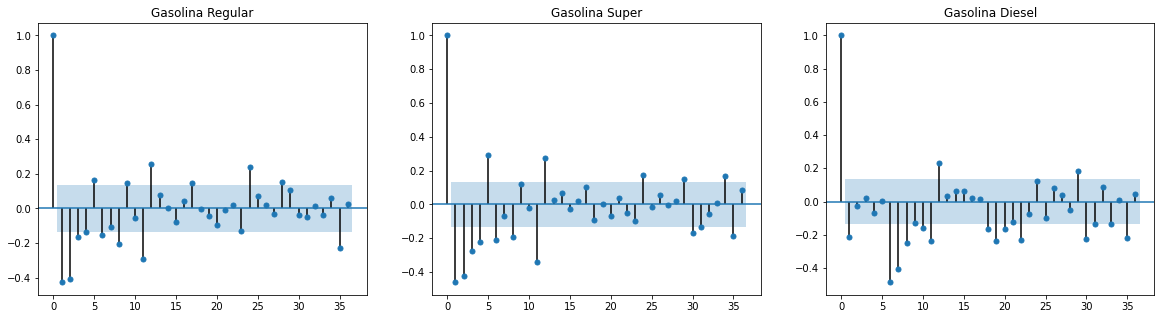

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plot_pacf(diffregularcon,  title = "Gasolina Regular",ax=axes[0], lags = 36) #p: 0
plot_pacf(diffsupercon, title = "Gasolina Super" ,ax=axes[1], lags = 36) #p: 1
plot_pacf(diffdieselcon, title = "Gasolina Diesel" ,ax=axes[2], lags = 36) #p: 1
plt.show()

Dada la correlación presentada y la forma de presentarse los datos, puede decirse que no existe una correlación parcial entre los datos, para ningún caso.

### Importaciones: Autocorrelación Parcial

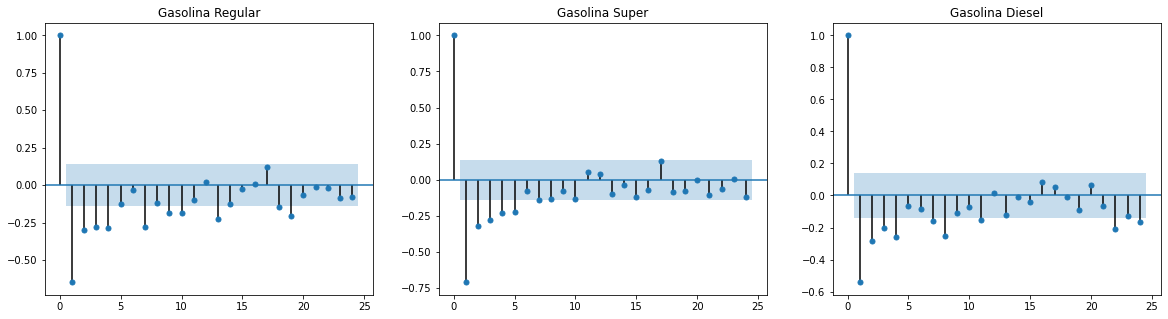

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plot_pacf(diffregularimp,  title = "Gasolina Regular",ax=axes[0]) #p: 2
plot_pacf(diffsuperimp, title = "Gasolina Super" ,ax=axes[1]) #p: 2
plot_pacf(diffdieselimp, title = "Gasolina Diesel" ,ax=axes[2]) #p: 2
plt.show()

Dada la correlación presentada y la forma de presentarse los datos, puede decirse que no existe una correlación parcial entre los datos, para ningún caso.

## Para encontrar q necesitamos ver los gráficos de Autocorrelación 

### Consumo: Autocorrelación 

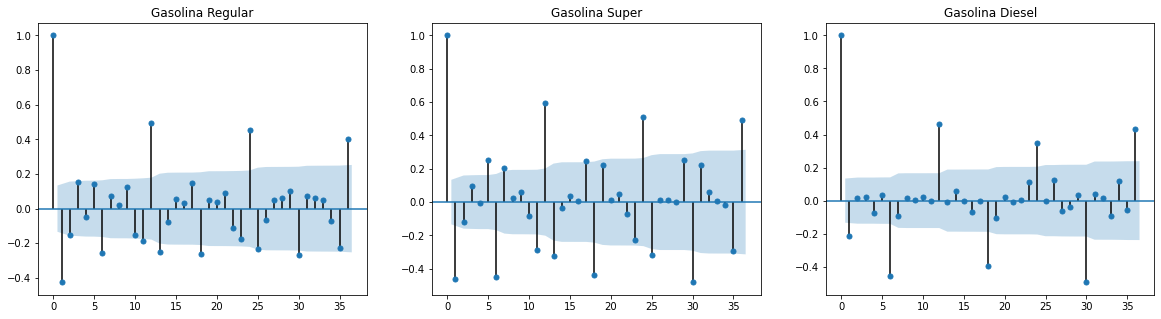

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plot_acf(diffregularcon,  title = "Gasolina Regular",ax=axes[0], lags = 36) #q: 0
plot_acf(diffsupercon, title = "Gasolina Super" ,ax=axes[1], lags = 36) #q: 2
plot_acf(diffdieselcon, title = "Gasolina Diesel" ,ax=axes[2], lags = 36) #q: 2
plt.show()

Dada la correlación presentada y la forma de presentarse los datos, puede decirse que no existe una correlación parcial entre los datos, para ningún caso.

### Importaciones: Autocorrelación 

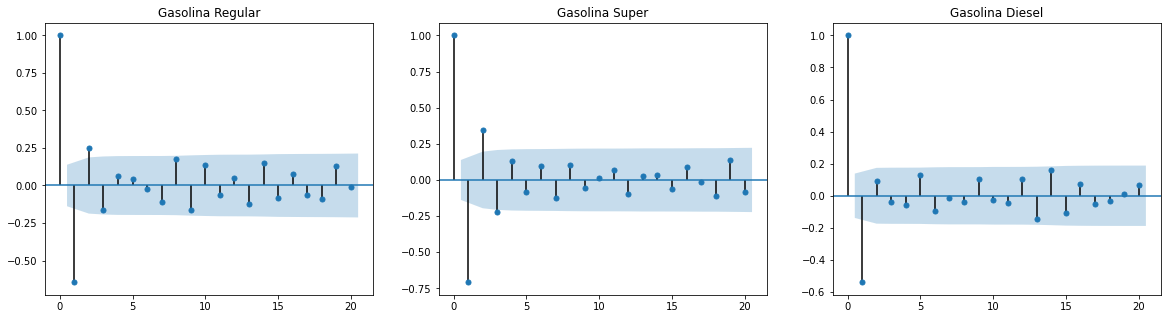

In [77]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plot_acf(diffregularimp,  title = "Gasolina Regular",ax=axes[0], lags = 20) #q: 2
plot_acf(diffsuperimp, title = "Gasolina Super" ,ax=axes[1], lags = 20) #q: 3
plot_acf(diffdieselimp, title = "Gasolina Diesel" ,ax=axes[2], lags = 20) #q: 1
plt.show()

Dada la correlación presentada y la forma de presentarse los datos, puede decirse que no existe una correlación parcial entre los datos, para ningún caso.

# Modelos Arima

### Modelo para el consumo de GasolinaRegular



In [78]:
data_con["GasolinaRegular"] = np.exp(data_con["GasolinaRegular"]).dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [79]:
modelregularcon = ARIMA(data_con["GasolinaRegular"].dropna(), order=(2,1,0))
model_fit_reg_con = modelregularcon.fit(disp=0)
print(model_fit_reg_con.summary())

                             ARIMA Model Results                              
Dep. Variable:      D.GasolinaRegular   No. Observations:                  215
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2466.999
Method:                       css-mle   S.D. of innovations          23249.284
Date:                Fri, 06 Aug 2021   AIC                           4941.999
Time:                        20:04:36   BIC                           4955.482
Sample:                    02-01-2000   HQIC                          4947.447
                         - 12-01-2017                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1524.6489    768.426      1.984      0.047      18.561    3030.737
ar.L1.D.GasolinaRegular    -0.6516      0.063    -10.390      0.000      -0.774      -0.529


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

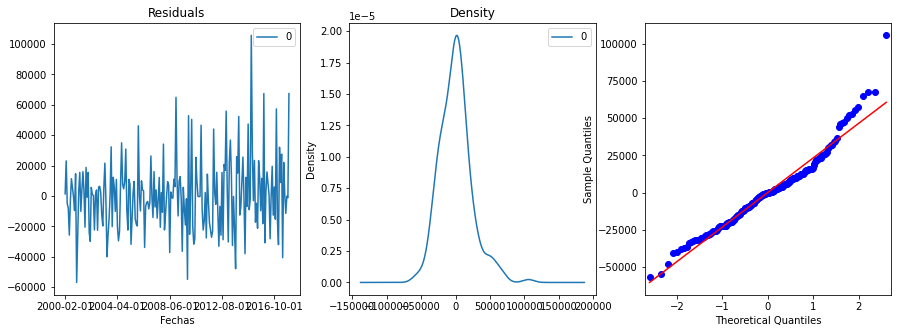

In [80]:
# Plot residual errors
residuals = pd.DataFrame(model_fit_reg_con.resid)
fig, ax = plt.subplots(1,3, figsize = (15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
sm.qqplot(residuals[0], line = "s", ax = ax[2])

plt.show()

A partir de las gráficas, es posible observar un comportamiento normal para los residuales, así como para la densidad, lo que habla favorablemente del modelo.

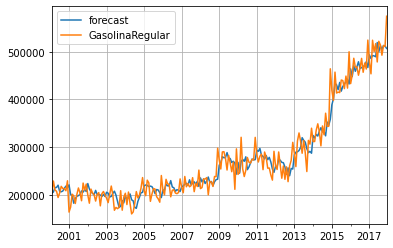

In [81]:
model_fit_reg_con.plot_predict(dynamic=False)
plt.grid()
plt.show()

Comparando los resultados predichos, con los resultados reales, puede verse que el modelo realizado es apropiado y tiene una alta certeza. 

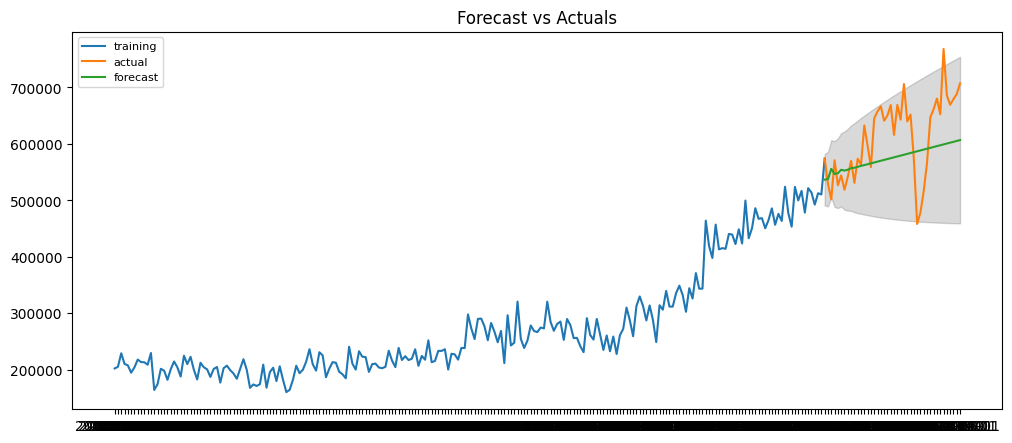

In [82]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  

# Forecast
fc, se, conf = model_fit_reg_con.forecast(42, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=data_con_test["GasolinaRegular"].index)
lower_series = pd.Series(conf[:, 0], index=data_con_test["GasolinaRegular"].index)
upper_series = pd.Series(conf[:, 1], index=data_con_test["GasolinaRegular"].index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_con["GasolinaRegular"], label='training')
plt.plot(data_con_test["GasolinaRegular"], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8) 
plt.show()

Como se observa en la gráfica, la data de entrenamiento presenta un comportamiento similiar a la fata real y, los procesos actuales están distintos a las predicciones, dado que las últimas son lineales.

### Modelo para el consumo de GasolinaSuper

In [83]:
data_con["GasolinaSuper"] = np.exp(data_con["GasolinaSuper"]).dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [84]:
modelsupercon = ARIMA(data_con["GasolinaSuper"].dropna(), order=(1,1,2))
model_fit_super_con = modelsupercon.fit(disp=0)
print(model_fit_super_con.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

                             ARIMA Model Results                              
Dep. Variable:        D.GasolinaSuper   No. Observations:                  215
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2503.155
Method:                       css-mle   S.D. of innovations          27489.548
Date:                Fri, 06 Aug 2021   AIC                           5016.310
Time:                        20:04:40   BIC                           5033.164
Sample:                    02-01-2000   HQIC                          5023.120
                         - 12-01-2017                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1320.2575    469.893      2.810      0.005     399.284    2241.231
ar.L1.D.GasolinaSuper    -0.7878      0.081     -9.769      0.000      -0.946      -0.630
ma.L1.D.

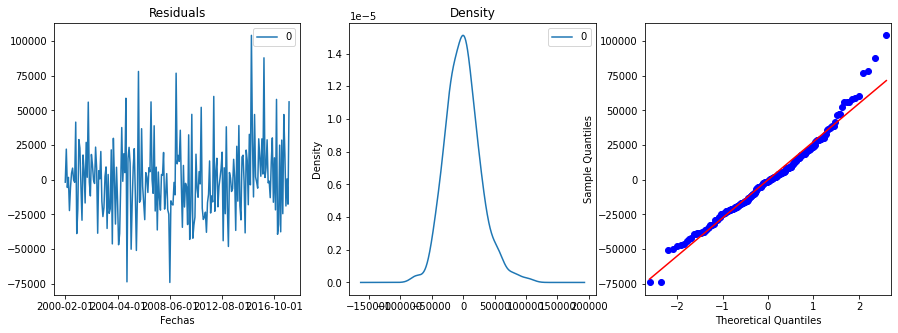

In [85]:
# Plot residual errors
residuals = pd.DataFrame(model_fit_super_con.resid)
fig, ax = plt.subplots(1,3, figsize = (15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
sm.qqplot(residuals[0], line = "s", ax = ax[2])

plt.show()

A partir de las gráficas, es posible observar un comportamiento normal para los residuales, así como para la densidad, lo que habla favorablemente del modelo.

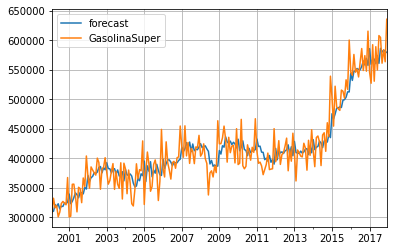

In [86]:
model_fit_super_con.plot_predict(dynamic=False)
plt.grid()
plt.show()

Comparando los resultados predichos, con los resultados reales, puede verse que el modelo realizado es apropiado y tiene una alta certeza. 

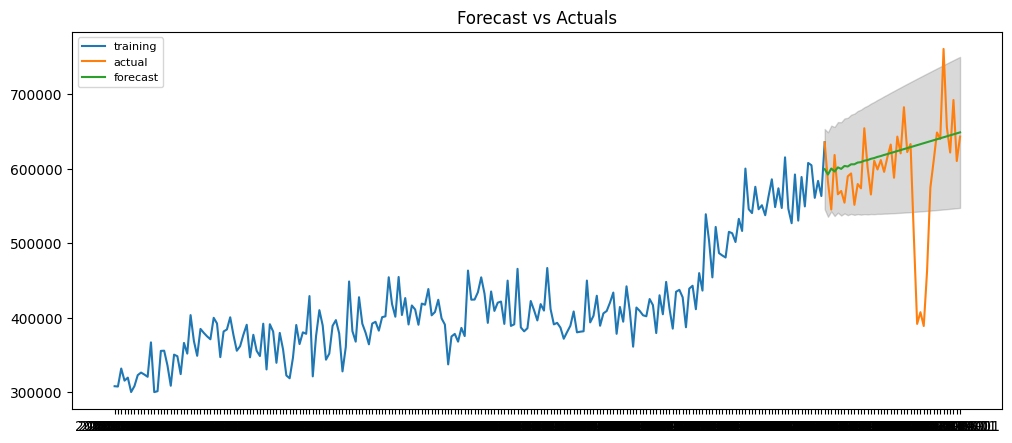

In [87]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  

# Forecast
fc, se, conf = model_fit_super_con.forecast(42, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=data_con_test["GasolinaSuper"].index)
lower_series = pd.Series(conf[:, 0], index=data_con_test["GasolinaSuper"].index)
upper_series = pd.Series(conf[:, 1], index=data_con_test["GasolinaSuper"].index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_con["GasolinaSuper"], label='training')
plt.plot(data_con_test["GasolinaSuper"], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8) 
plt.show()

Como se observa en la gráfica, la data de entrenamiento presenta un comportamiento similiar a la fata real y, los procesos actuales están distintos a las predicciones, dado que las últimas son lineales.

### Modelo para el consumo de Diesel

In [88]:
data_con["Diesel"] = np.exp(data_con["Diesel"]).dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [89]:
modeldieselcon = ARIMA(data_con["Diesel"].dropna(), order=(1,1,2))
model_fit_diesel_con = modeldieselcon.fit(disp=0)
print(model_fit_diesel_con.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

                             ARIMA Model Results                              
Dep. Variable:               D.Diesel   No. Observations:                  215
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2701.282
Method:                       css-mle   S.D. of innovations          68958.017
Date:                Fri, 06 Aug 2021   AIC                           5412.564
Time:                        20:04:44   BIC                           5429.417
Sample:                    02-01-2000   HQIC                          5419.373
                         - 12-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1798.2620    386.752      4.650      0.000    1040.241    2556.283
ar.L1.D.Diesel     0.6502      0.091      7.148      0.000       0.472       0.829
ma.L1.D.Diesel    -1.0086      0.104

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


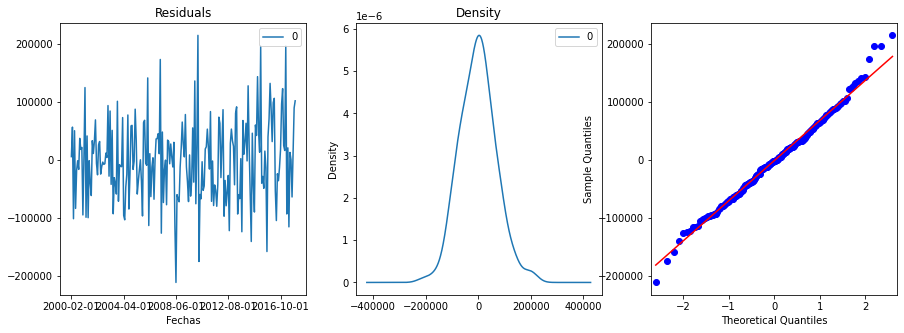

In [90]:
# Plot residual errors
residuals = pd.DataFrame(model_fit_diesel_con.resid)
fig, ax = plt.subplots(1,3, figsize = (15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
sm.qqplot(residuals[0], line = "s", ax = ax[2])

plt.show()

A partir de las gráficas, es posible observar un comportamiento normal para los residuales, así como para la densidad, lo que habla favorablemente del modelo.


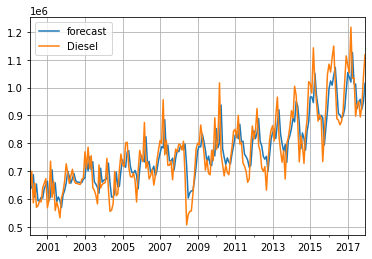

In [91]:
model_fit_diesel_con.plot_predict(dynamic=False)
plt.grid()
plt.show()

Comparando los resultados predichos, con los resultados reales, puede verse que el modelo realizado es apropiado y tiene una alta certeza. 

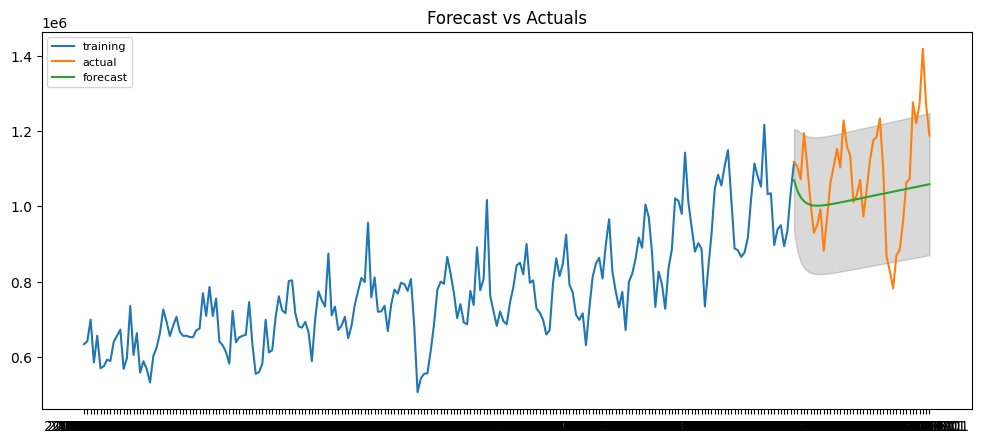

In [92]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  

# Forecast
fc, se, conf = model_fit_diesel_con.forecast(42, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=data_con_test["Diesel"].index)
lower_series = pd.Series(conf[:, 0], index=data_con_test["Diesel"].index)
upper_series = pd.Series(conf[:, 1], index=data_con_test["Diesel"].index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_con["Diesel"], label='training')
plt.plot(data_con_test["Diesel"], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8) 
plt.show()

Como se observa en la gráfica, la data de entrenamiento presenta un comportamiento similiar a la fata real y, los procesos actuales están distintos a las predicciones, dado que las últimas son lineales.

### Modelo para la importación de GasolinaRegular

In [95]:
data_imp["GasolinaRegular"] = np.exp(data_imp["GasolinaRegular"]).dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [96]:
modeloRegImp = ARIMA(data_imp["GasolinaRegular"].dropna(), order=(1,1,2))
model_fit_reg_imp = modeloRegImp.fit(disp=0)
print(model_fit_reg_imp.summary())

                             ARIMA Model Results                              
Dep. Variable:      D.GasolinaRegular   No. Observations:                  201
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2542.339
Method:                       css-mle   S.D. of innovations          74981.360
Date:                Fri, 06 Aug 2021   AIC                           5094.679
Time:                        20:16:01   BIC                           5111.195
Sample:                    02-01-2001   HQIC                          5101.362
                         - 10-01-2017                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1794.4560    632.079      2.839      0.005     555.603    3033.309
ar.L1.D.GasolinaRegular    -0.7487      0.132     -5.658      0.000      -1.008      -0.489


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

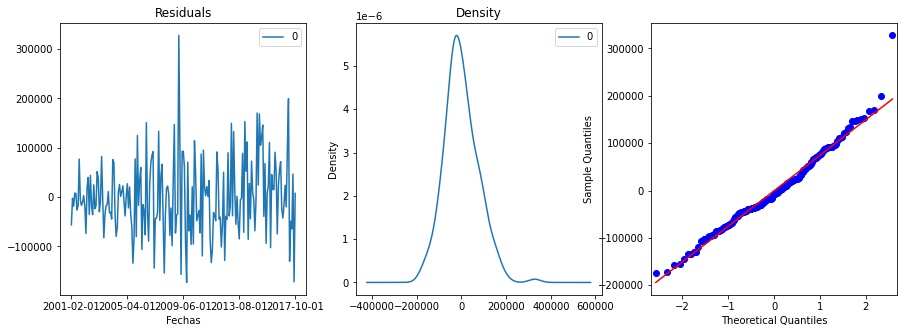

In [97]:

# Grafica residuals
residuals = pd.DataFrame(model_fit_reg_imp.resid)
fig, ax = plt.subplots(1,3, figsize = (15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
sm.qqplot(residuals[0], line = "s", ax = ax[2])

plt.show()

A partir de las gráficas, es posible observar un comportamiento normal para los residuales, así como para la densidad, lo que habla favorablemente del modelo.

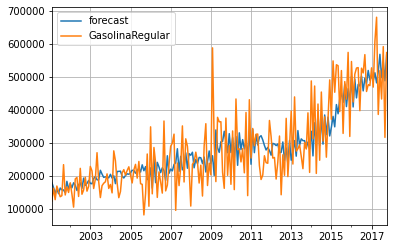

In [98]:
model_fit_reg_imp.plot_predict(dynamic=False)
plt.grid()
plt.show()

Comparando los resultados predichos, con los resultados reales, puede verse que el modelo realizado es apropiado y tiene una alta certeza.

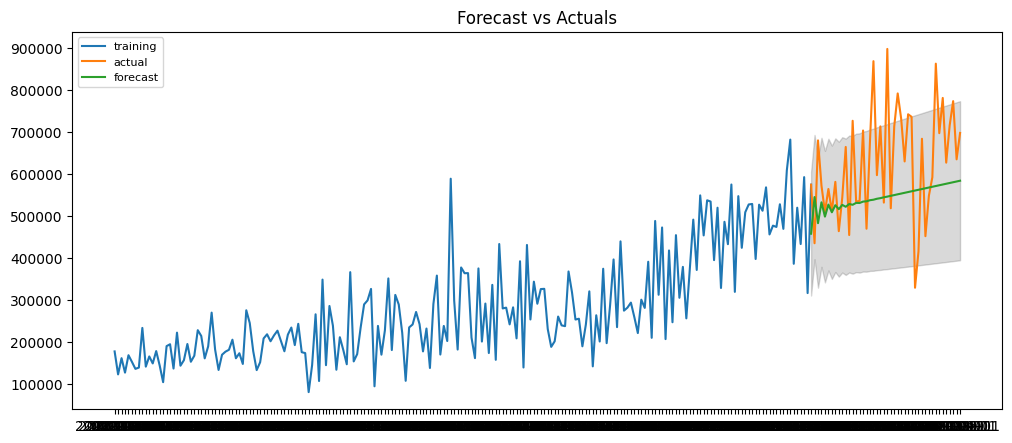

In [99]:
#Modelo ARIMA
#Forecast
fc, se, conf = model_fit_reg_imp.forecast(44, alpha=0.05)  # 95% conf

#Series
fc_series = pd.Series(fc, index=data_imp_test["GasolinaRegular"].index)
lower_series = pd.Series(conf[:, 0], index=data_imp_test["GasolinaRegular"].index)
upper_series = pd.Series(conf[:, 1], index=data_imp_test["GasolinaRegular"].index)

#Grafica
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_imp["GasolinaRegular"], label='training')
plt.plot(data_imp_test["GasolinaRegular"], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8) 
plt.show()

Como se observa en la gráfica, la data de entrenamiento presenta un comportamiento similiar a la fata real y, los procesos actuales están distintos a las predicciones, dado que las últimas son lineales.

### Modelo para la importación de GasolinaSuper

In [100]:
data_imp["GasolinaSuper"] = np.exp(data_imp["GasolinaSuper"]).dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [101]:
modeloSupImp = ARIMA(data_imp["GasolinaSuper"].dropna(), order=(1,1,2))
model_fit_sup_imp = modeloSupImp.fit(disp=0)
print(model_fit_sup_imp.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

                             ARIMA Model Results                              
Dep. Variable:        D.GasolinaSuper   No. Observations:                  201
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  15.771
Method:                       css-mle   S.D. of innovations              0.223
Date:                Fri, 06 Aug 2021   AIC                            -21.542
Time:                        20:18:23   BIC                             -5.026
Sample:                    02-01-2001   HQIC                           -14.859
                         - 10-01-2017                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0036      0.001      2.494      0.013       0.001       0.006
ar.L1.D.GasolinaSuper    -0.6147      0.150     -4.106      0.000      -0.908      -0.321
ma.L1.D.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


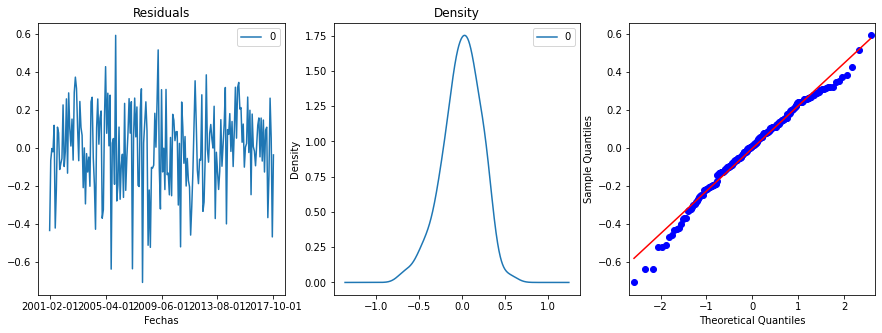

In [102]:
#Grafica residuals
residuals = pd.DataFrame(model_fit_sup_imp.resid)
fig, ax = plt.subplots(1,3, figsize = (15,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
sm.qqplot(residuals[0], line = "s", ax = ax[2])

plt.show()

A partir de las gráficas, es posible observar un comportamiento normal para los residuales, así como para la densidad, lo que habla favorablemente del modelo.

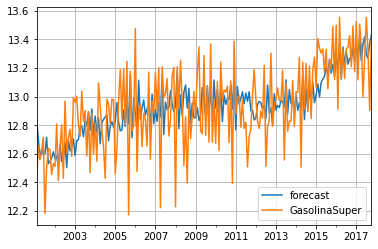

In [103]:
model_fit_sup_imp.plot_predict(dynamic=False)
plt.grid()
plt.show()

Comparando los resultados predichos, con los resultados reales, puede verse que el modelo realizado es apropiado y tiene una alta certeza.

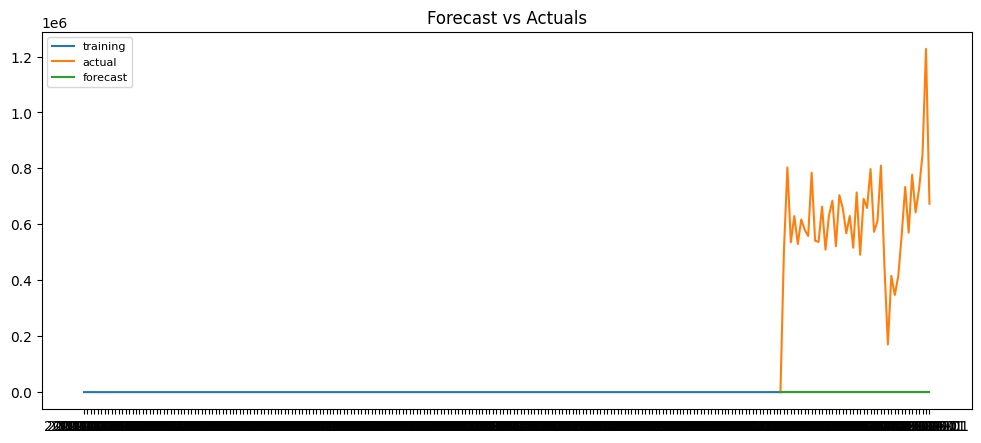

In [104]:

#Modelo ARIMA
# Forecast
fc, se, conf = model_fit_sup_imp.forecast(44, alpha=0.05)  # 95% conf

#Series
fc_series = pd.Series(fc, index=data_imp_test["GasolinaSuper"].index)
lower_series = pd.Series(conf[:, 0], index=data_imp_test["GasolinaSuper"].index)
upper_series = pd.Series(conf[:, 1], index=data_imp_test["GasolinaSuper"].index)

#Grafica
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_imp["GasolinaSuper"], label='training')
plt.plot(data_imp_test["GasolinaSuper"], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8) 
plt.show()

Como se observa en la gráfica, la data de entrenamiento presenta un comportamiento similiar a la fata real y, los procesos actuales están distintos a las predicciones, dado que las últimas son lineales.

### Modelo para la importación de Diesel

## Algoritmo Prophet

De forma inicial, dados los requisitos para la función de Prophet, creamos una función que transforme los datos a la forma deseada, para luego crear un dataframe con estos.

In [106]:
def prophet_data(df):
  fechas = []
  data = []

  for i in range(0, len(df)):
    fechas.append(df.index[i])
    data.append(df[i])

  return pd.DataFrame({"ds": fechas, "y": data })

### Consumo GasolinaRegular

In [109]:
#Se seleccionan los datos del dataframe
data= prophet_data(data_con["GasolinaRegular"])

model = Prophet()
# Vemos si el modelo concuerda con la data
model.fit(data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds           yhat     yhat_lower     yhat_upper
0 2017-12-01  572495.820658  550604.156444  595514.073444
1 2018-01-01  542115.645864  520481.560092  564437.435163
2 2018-02-01  535319.405229  512561.877400  557789.704471
3 2018-03-01  574220.253760  551336.401739  595698.339780
4 2018-04-01  565051.060437  542530.626101  589117.671134


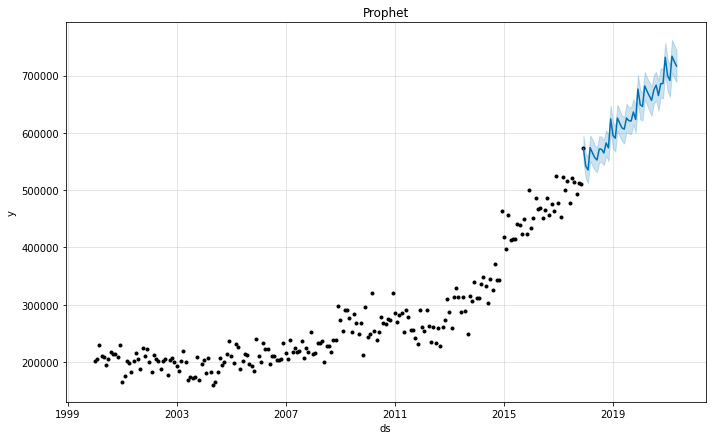

In [110]:
# se define el periodo para el cual se busca el pronóstico
future = list()
for i in range(0, len(data_con_test)):
	date = data_con_test.index[i]
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.title("Prophet")
plt.show()

### Consumo GasolinaSuper

In [111]:
data = prophet_data(data_con["GasolinaSuper"])

model = Prophet()
# fit the model
model.fit(data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds           yhat     yhat_lower     yhat_upper
0 2017-12-01  654754.045289  629879.011291  679728.393883
1 2018-01-01  606494.282133  582258.972860  631591.845664
2 2018-02-01  598922.988772  571470.903697  621980.986132
3 2018-03-01  638965.370074  613567.408820  663420.913686
4 2018-04-01  620687.802400  595046.472286  643647.273609


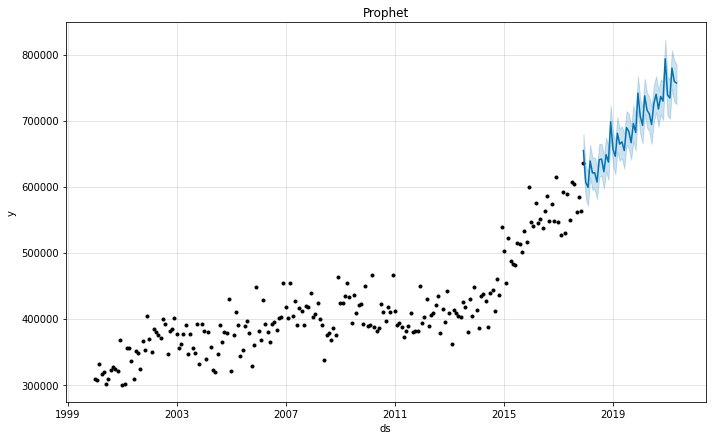

In [112]:
# define the period for which we want a prediction
future = list()
for i in range(0, len(data_con_test)):
	date = data_con_test.index[i]
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.title("Prophet")
plt.show()

### Consumo Diesel

In [113]:
data = prophet_data(data_con["Diesel"])

model = Prophet()
# fit the model
model.fit(data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds          yhat    yhat_lower    yhat_upper
0 2017-12-01  1.102381e+06  1.037687e+06  1.163847e+06
1 2018-01-01  1.097183e+06  1.032564e+06  1.163456e+06
2 2018-02-01  1.087337e+06  1.022304e+06  1.150923e+06
3 2018-03-01  1.189663e+06  1.126957e+06  1.252046e+06
4 2018-04-01  1.093089e+06  1.027392e+06  1.158950e+06


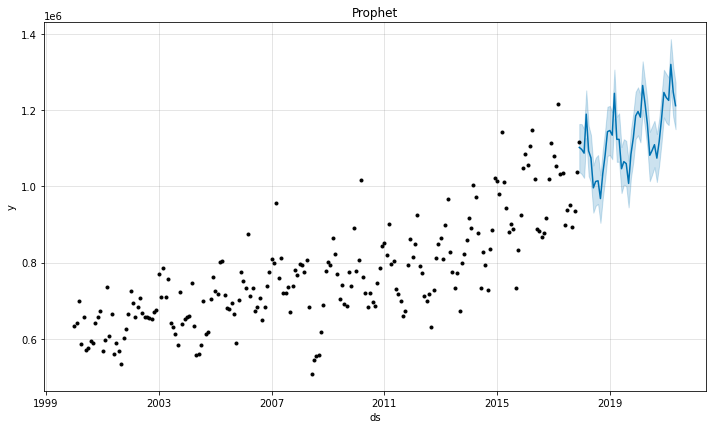

In [114]:
# define the period for which we want a prediction
future = list()
for i in range(0, len(data_con_test)):
	date = data_con_test.index[i]
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.title("Prophet")
plt.show()

### Importaciones GasolinaRegular

In [115]:
data= prophet_data(data_imp["GasolinaRegular"])

model = Prophet()
# fit the model
model.fit(data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds           yhat     yhat_lower     yhat_upper
0 2017-10-01  514709.308201  418515.114819  607811.728184
1 2017-11-01  492510.446274  393217.941822  590654.525513
2 2017-12-01  504505.055513  412244.558802  602750.818538
3 2018-01-01  535185.470022  435747.402919  628773.282975
4 2018-02-01  537216.688083  446400.710270  633227.661214


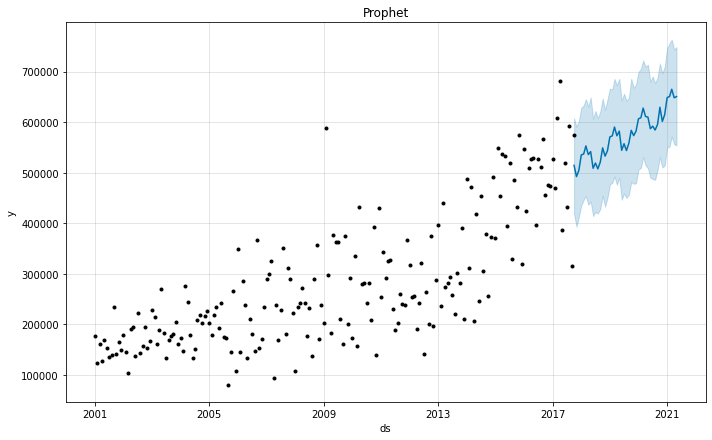

In [116]:
# define the period for which we want a prediction
future = list()
for i in range(0, len(data_imp_test)):
	date = data_imp_test.index[i]
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.title("Prophet")
plt.show()

### Importaciones GasolinaSuper

In [117]:
data = prophet_data(data_imp["GasolinaSuper"])

model = Prophet()
# fit the model
model.fit(data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds       yhat  yhat_lower  yhat_upper
0 2017-10-01  13.396784   13.109948   13.667186
1 2017-11-01  13.357081   13.071321   13.613195
2 2017-12-01  13.424047   13.161064   13.708549
3 2018-01-01  13.420089   13.143051   13.693966
4 2018-02-01  13.392552   13.114374   13.668124


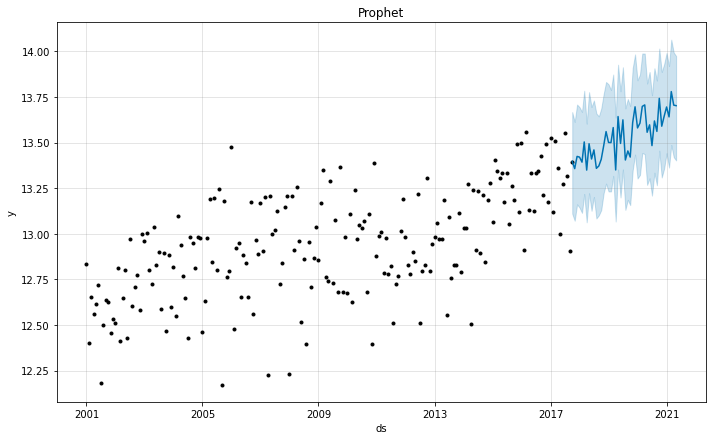

In [118]:
# define the period for which we want a prediction
future = list()
for i in range(0, len(data_imp_test)):
	date = data_imp_test.index[i]
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.title("Prophet")
plt.show()

### Importaciones Diesel

In [119]:
data = prophet_data(data_imp["Diesel"])

model = Prophet()
# fit the model
model.fit(data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds      yhat  yhat_lower  yhat_upper
0 2017-10-01  2.622130    2.600530    2.643802
1 2017-11-01  2.626431    2.606052    2.647802
2 2017-12-01  2.643622    2.623212    2.664301
3 2018-01-01  2.640390    2.618698    2.659923
4 2018-02-01  2.630064    2.610539    2.651833


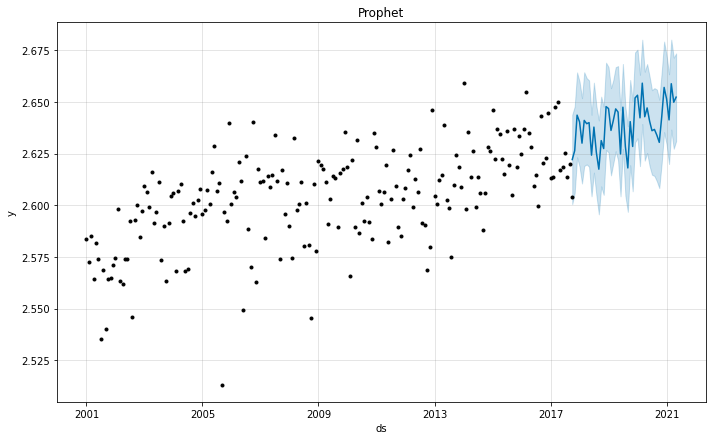

In [120]:
# define the period for which we want a prediction
future = list()
for i in range(0, len(data_imp_test)):
	date = data_imp_test.index[i]
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.title("Prophet")
plt.show()